Seminar: Kernel Adaptive Filter, SoSe 2018 <br>

NUE, Institut für Telekommunikationssysteme, TU Berlin

Supervision: M.Sc. Liven Lange, Prof. Dr.-Ing. Sikora

By: Gabriel Dernbach

# Preparation

## Import Libraries

We use the standard libraries for numerical computation in python. These are numpy for matrix classes and operations, scientific python for linear algebra operations und signal processing as well as matplotlib for visualization. Configurations are made to create print friendly visualizations.

In [400]:
import numpy as np
import scipy.signal as sig
from scipy.linalg import toeplitz
import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1)

In [401]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

---

## Implementation of Least Mean Squares Algorithm

Steps of the least mean squares algorithm:
0. initialize
$$\underline{w}[0] = \underline{0}$$
$$\mu > 0$$

1. prediction
$$y[k] = \underline{w}^t[k]\underline{x}[k]$$
2. error evaluation
$$ e[k] = d[k] - y[k]$$
3. update of coefficient vector
$$\underline{w}[k+1] = \underline{w}[k] = \mu e[k]\underline{x}[k]$$

In [402]:
# reference Moschytz, G., & Hofbauer, M. (2000). 
# Adaptive Filter. Berlin ua: Springer. p.121

def lms_update(x,d,w,mu=0.01):
    '''
    perform a least mean square weight update.
    takes an input signal x, the disred signal d and the prior 
    weight vector to calculate the momentary error and update the weigths.
    '''
    # predict y by scalar product of w and x.
    y = w@x
    # obtain error as difference to d.
    e = d - y
    # update w by scaled version of x.
    w_new = w + mu * e * x
    
    # record error squared for performance measure.
    error = e**2
    
    return w_new, error


def lms(N,d,x,mu=0.01):
    '''
    perform the least mean square algorithm on every samples.
    takes the number of taps 'N', a disred signal 'd', an input signal 'x'
    and a learning rate 'mu' and returns the history of 
    weight vectors 'w' and error 'e'.
    '''
    # for each iteration we want N pervious values of x.
    # in toeplitz each column holds the previous terms in descending order.
    # limit number of rows to N.
    X = toeplitz(x)[:N,:]
    
    # prealloacte wight vector and error history.
    w = np.zeros((N,len(d)+1))
    error = np.zeros(len(d))
    
    # iterate over signal and recursively update the weights.
    for i in range(0,len(d)):
        # record output of lms_update and feed it back to it.
        w[:,i+1],error[i] = lms_update(X[:,i],d[i],w[:,i],mu)
    
    return w, error

---

## Implementation of Recursive Least Squares Algorithm

steps of the recursive least squares algorithm:
0. initialization:
$$\mathfrak{R}^{-1}_0 = \eta \boldsymbol{I}_N$$
$$\underline{w}^\circ = \underline{0}$$
1. prior prediction:
$$y_{\circ}[k] = \underline{x}^t[k]\underline{w}_{k-1}^\circ$$
2. prior error:
$$ e_{\circ}[k] = d[k] - y_{\circ}[k]$$
3. filtered normalized data vector:
$$\tilde{\underline{z}}_k= \frac{\mathfrak{R}^{-1}_{k-1}\underline{x}[k]}{\rho + \underline{x}^t[k] \mathfrak{R}^{-1}_{k-1} \underline{x}[k]}$$ 
4. update of opimtal weight vector:
$$\underline{w}_k^{\circ} = \underline{w}_{k-1}^{\circ} + e_0[k]\tilde{\underline{z}}_k$$
5. update of inverse deterministic auto correlation matrix:
$$\mathfrak{R}^{-1}_k = \frac{1}{\rho} ( \mathfrak{R}^{-1}_{k-1} - \tilde{\underline{z}}_k \underline{x}^t \mathfrak{R}^{-1}_{k-1})$$

In [403]:
# reference Moschytz, G., & Hofbauer, M. (2000). 
# Adaptive Filter. Berlin ua: Springer. p.145

def rls_update(x,d,Rinv,w,rho):
    '''
    perform a recursive least squares weight update.
    takes an input signal 'x', the disred signal 'd', the 
    prior inverted determinist autocorrelation matrix 'Rinv',
    and the prior weight vector 'w' to calculate the momentary error,
    update the weigths 'w' and update 'Rinv'.
    '''
    # predict y by scalar product of w and x
    y = w @ x
    # obtain error as difference to d
    e = d - y
    # filtered normalized data vector
    z = Rinv@x / (1 + x @ Rinv @ x)
    # update w by adding scaled version of z
    w_new = w + e * z
    # update Rinv
    Rinv = (1/rho) * (Rinv - np.outer(z,x) @ Rinv)
    return w_new, Rinv, e**2

def rls(N,d,x,rho=1,eta=1000000):
    '''
    perform the recursive least squares algorithm on every samples.
    takes the number of taps 'N', a disred signal 'd', an input signal 'x'
    and an initial value for Rinv 'eta' and returns history of 
    weight vectors 'w' and error 'e'.
    '''
    X = toeplitz(x)[:N,:] # every column is input for time t

    Rinv = eta * np.eye(N,N)
    # initialize wight vector and error history
    w = np.zeros((N,len(d)+1))
    error = np.zeros(len(d))
    
    # compute rlms for every point
    for i in range(0,len(d)):
        # update weight vector and collect error
        w[:,i+1], Rinv, error[i] = rls_update(X[:,i],d[i],Rinv,w[:,i],rho)
    
    return w, error


---

## Helper Functions Plotting

In [469]:
def rms(X):
    '''
    standart root mean square, 
    expects X to be a row vector
    '''
    return 1/X.shape[0]*np.sum(np.square(X))

def addnoise(X,var):
    '''
    adds noise of variance 'var' to input vector X
    it will help simulate measurement noise
    '''
    length = X.shape
    std = np.sqrt(var)
    XN = X + np.random.normal(0,std,length)
    return XN

def smooth(X,N=200):
    '''
    smoothing vector X 
    by moving average of N=200 values
    '''
    window = np.ones((N,))/N
    return np.convolve(X,window,mode='valid')

def plot(values,label='',stop=-1, linewidth=1):
    '''
    automatically apply smoothing,
    set defaults for linewidth and legends
    '''
    plt.xlabel('setp of iteration'); plt.ylabel('squared prediction error')
    plt.plot(smooth(values[:stop]),linewidth=linewidth,label=label);
    plt.legend(); 

---

---

# FIR System Identification

## Given FIR Filter

## Load Given Data

In [470]:
FIR = sio.loadmat('AF2018/System_FIR3.mat') # load provided data
Xfir = FIR['X'][0].astype('float64') # input signal
Dfir = FIR['D_'][0][0:10000].astype('float64') # desired signal

## Validate Desire Function To Given Coefficients

Let us first check if we can replicate the desired signal from the input signal by applying the given coefficients. We therefore create our own filter using the coefficients h0 to h4 and let it run on the input signal Xfir.

In [406]:
# FIR systems coefficients:
Hfir = np.array([0.7, 0.1, -0.03, 0.18, -0.24])
# create filter
Dfir_hat = sig.lfilter(tuple(Hfir),tuple([1,0]),tuple(Xfir))
# compare provided output to manual computation:
'Identical signals?', np.allclose(Dfir_hat,Dfir)

('Identical signals?', True)

By comparing the result Hfir with the desired signal Dfir we can confirm the testing setup.

In the derivation of LMS the input signal was assumed to be mean free.
Let us check if this the case for the given input.

In [407]:
# validate mean free input, check variance
np.mean(Xfir), np.var(Xfir)

(-0.004502597590200214, 1.011331682341236)

that is, we have a nearly mean free signal $\overline{x}$ with a $\sigma\approx1$

---

## Comparison of Number of Taps 

### LMS Number of Coefficients 

#### Theory

An adaptive filter which has less degrees of freedom
(filter taps) than the system it is supposed to model will fail to match as it can not reproduce the variance that lived in the missing dimensions. Therefore we expect a significantly worse fit of our model resulting in a poor performance in the region of convergence. The system with only few coefficients will adapt itslef within the boundary of it's possibility. We therefore expect a learning curve that descends at first. However when coming closer to an optimal solution it will not converge but will vary quiet strongly. The hight of the error in this region will be according to the missed variance.
In the opposit direction choosing a higher model complexity (many filter taps) for our adaptive filter than would be necessary for the system we are trying to identify is not expected to further reduce the error. This is because the additional degrees of freedom have no variance left and lack the data to develop a valuable mapping. The system is underdetermined and does not have a single optimum in the weight space. The error surface is not a paraboloid anymore but at least includes saddle points in the unnecessary dimensions.

We first check our implementation by comparing the resulting weight vector of the training phase of an $N=5$ taps LMS Filter to the given filter coefficients.

In [408]:
DfirN0001 = addnoise(Dfir,0.001) # add noise to desired function
print('identification successful?')
np.all(np.round(lms(5,DfirN0001,Xfir,0.001)[0][:,-1],2)==Hfir)

identification successful?


True

#### Simulation

In order to show the effects clearly the additional simulated measurement noise power was kept to a minimum. We also chose a relatively small learning rate $\mu$ so that the convergence can be observed more easily.

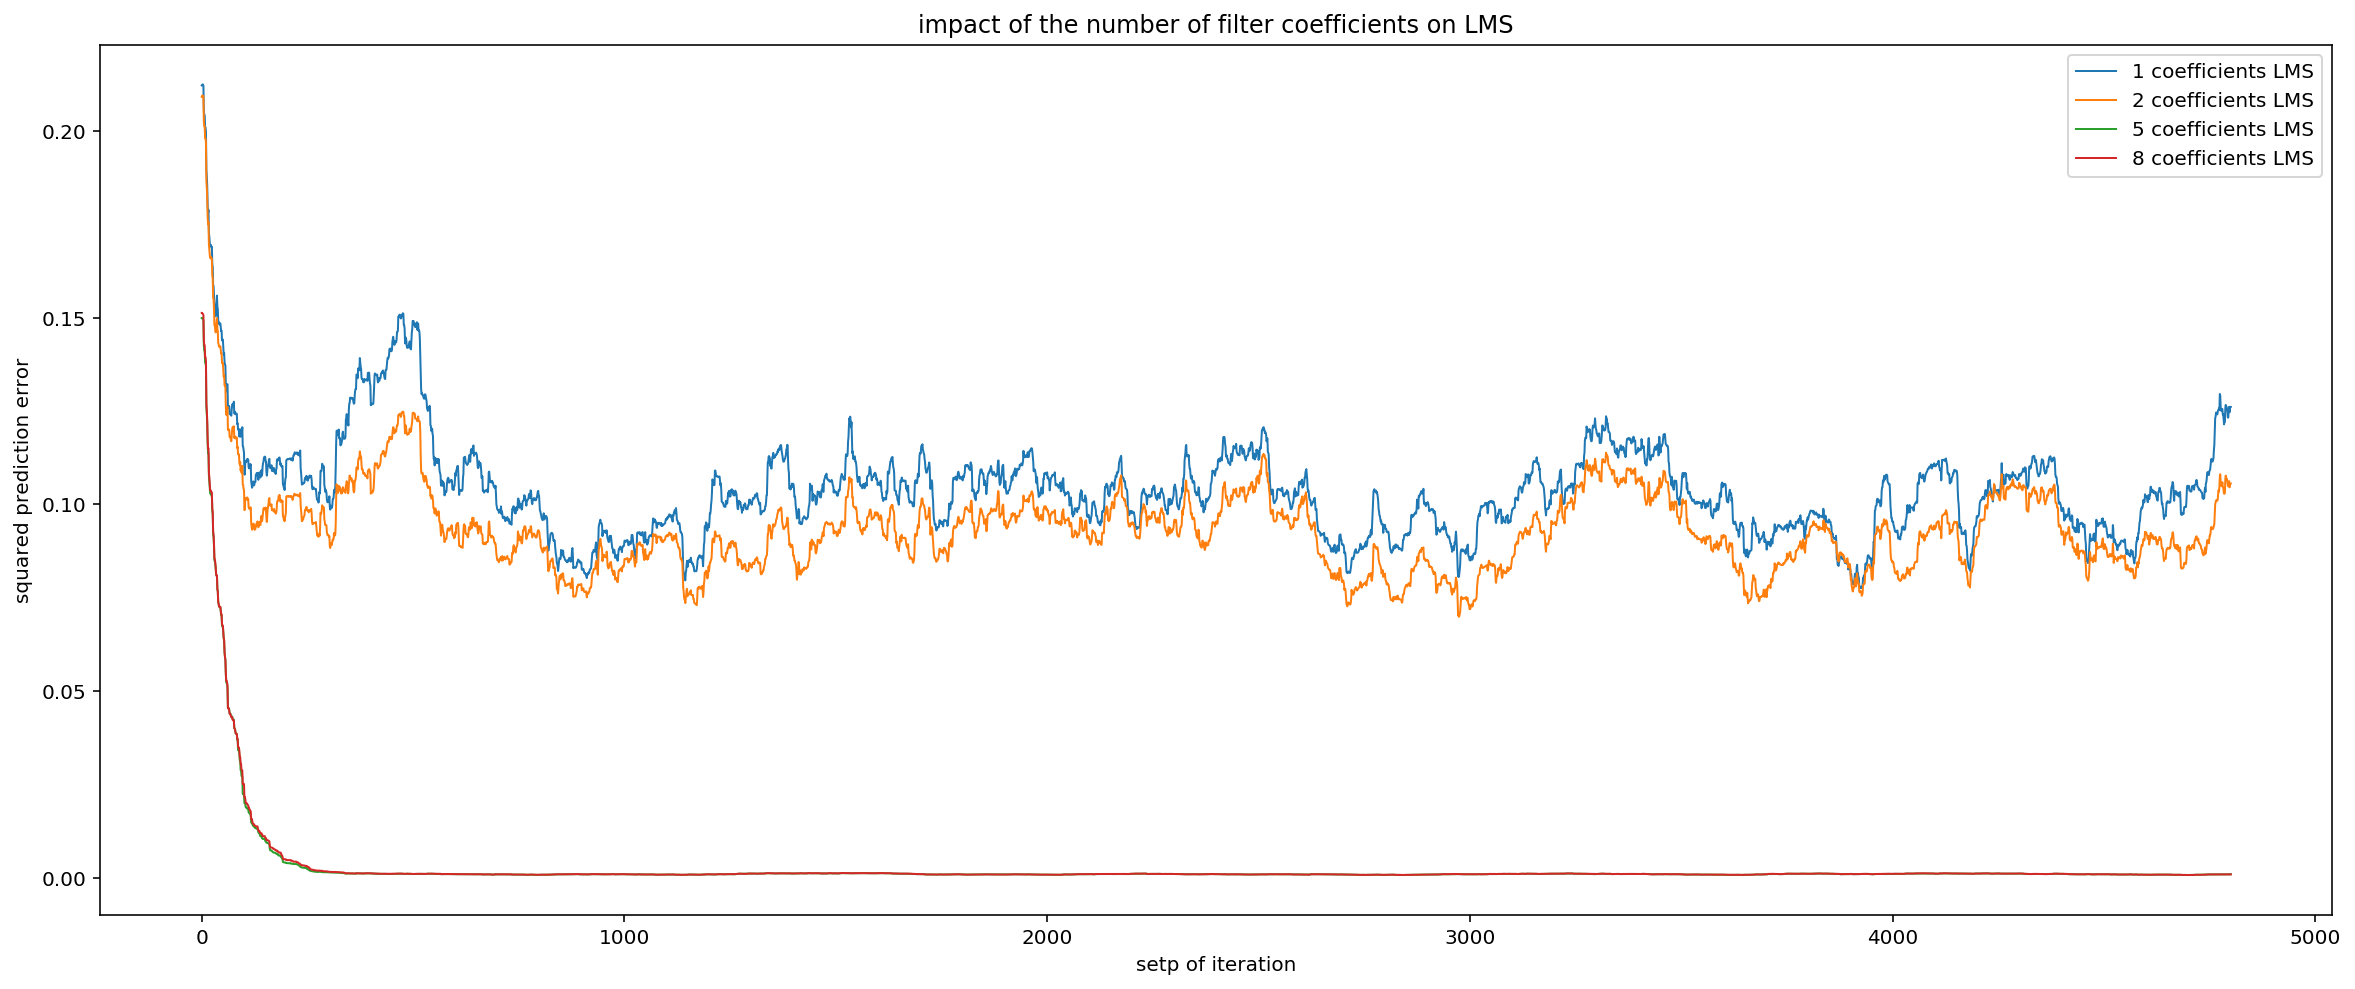

In [409]:
for taps in [1,2,5,8]:
    plot(lms(taps,DfirN0001,Xfir)[1],str(taps)+' coefficients LMS',5000)
plt.title('impact of the number of filter coefficients on LMS');

As can be seen from the graph, our expectation is fulfilled. The LMS with fewer than 5 coefficients (blue and orange) can reduce the error to some degree in the beginning but retain a rather high squared error. For the LMS with 5 coefficients (green) we can see, that the LMS performs a lot better, whereas for the case with 8 coefficients (red) we do not find any increase of performance.

### RLS Number of Coefficients

#### Theory

Similar considerations apply to the RLS algorithm. We first validate our algorithm with the $N=5$ coefficients case by comparing the the weights at the end of the learning phase to those that were given. 

In [410]:
print('identification successful?')
np.all(np.round(rls(5,DfirN0001,Xfir)[0][:,-1],2)==Hfir)

identification successful?


True

#### Simulation

As there is no learning rate to adjust in RLS the convergence could not be chosen to be slow and happens a lot faster than for the LMS. Besides that we expect similar results.

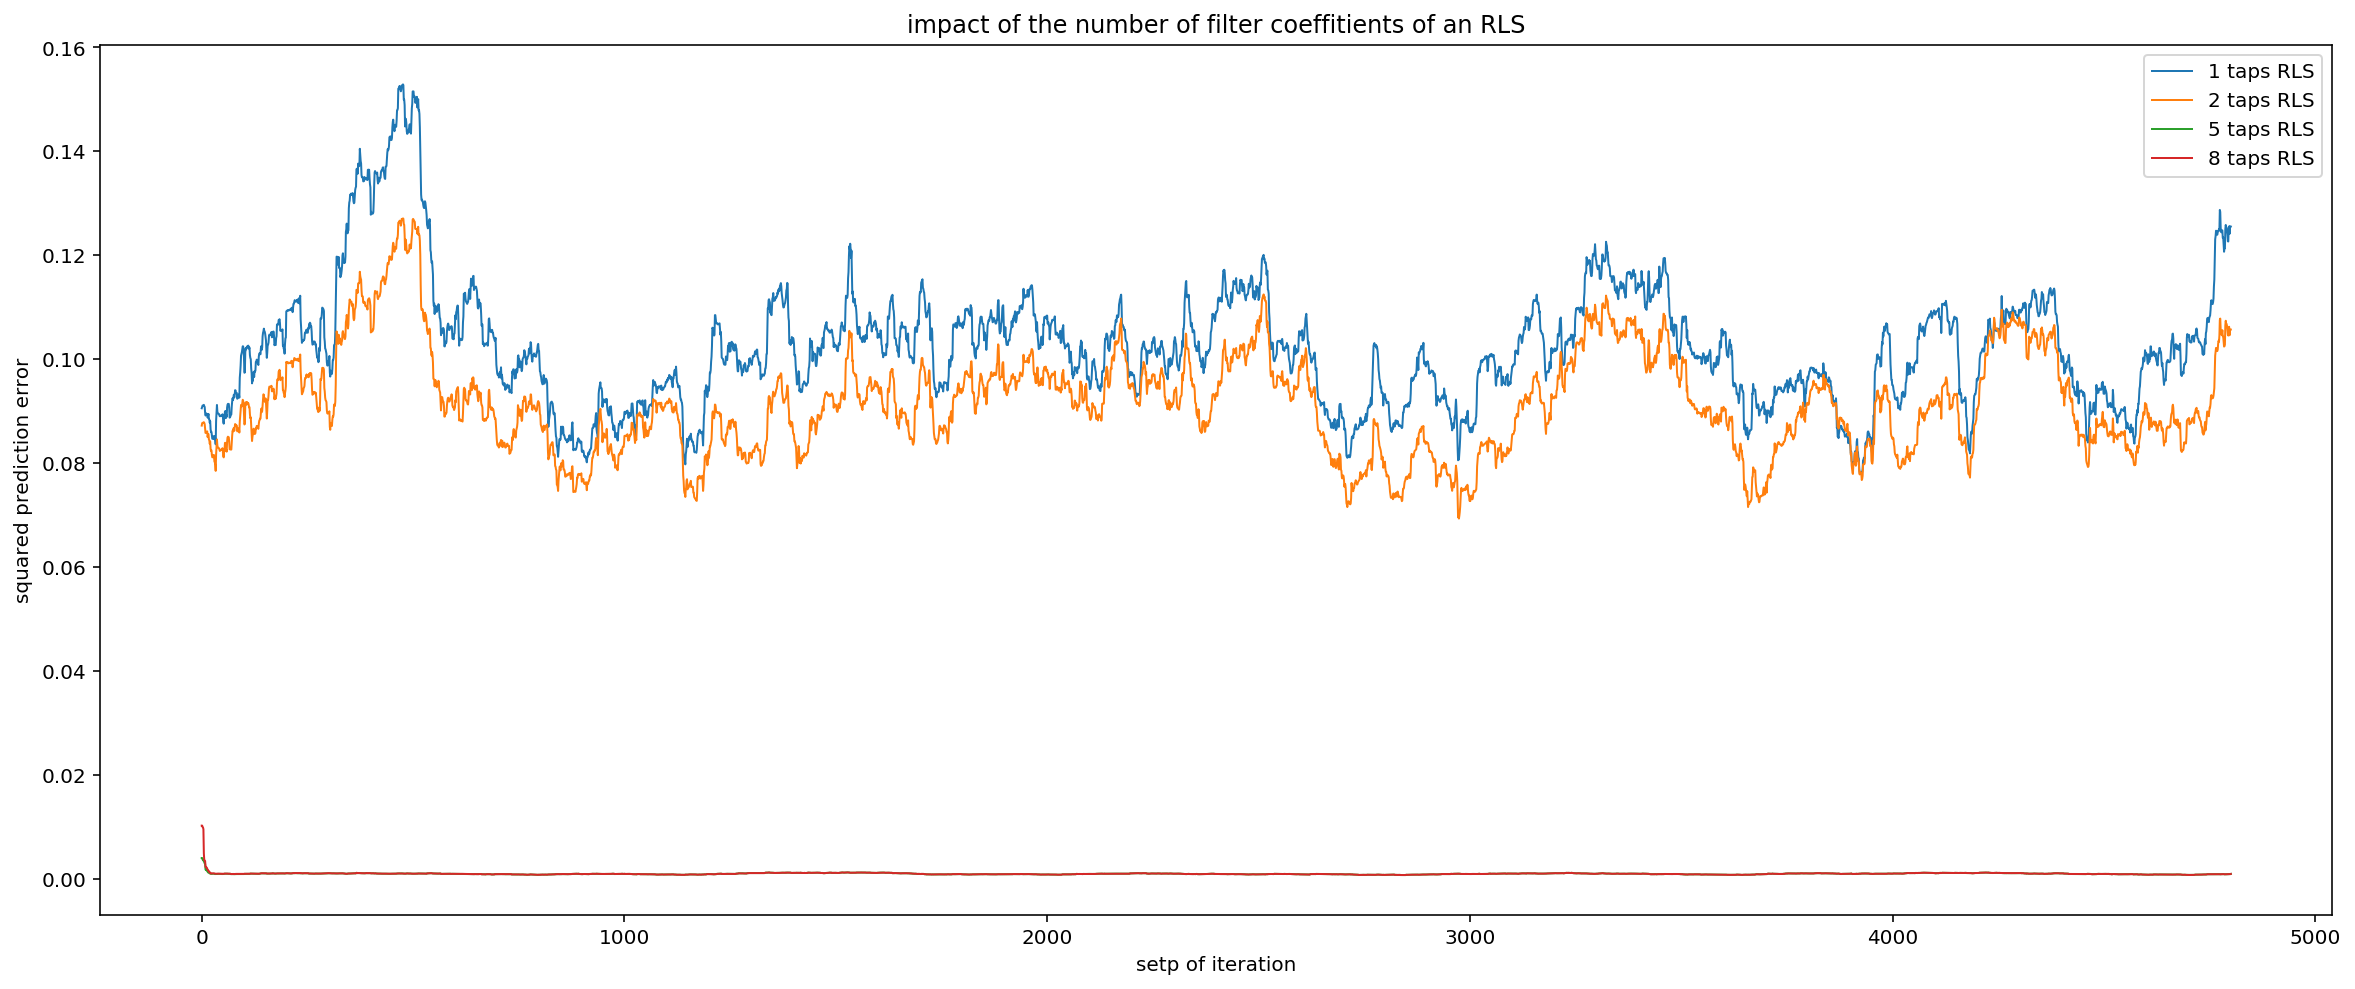

In [411]:
for taps in [1,2,5,8]:
    plot(rls(taps,DfirN0001,Xfir)[1],str(taps)+' taps RLS',5000) 
plt.title('impact of the number of filter coeffitients of an RLS');

Again we see that the algorithm gains in prediction performance when increasing the number of taps up to the required $N=5$ of the system that is to be identified.

### Fate ot Unnecessary Coefficients

When creating a filter with 20 taps it can be shown that all additional unnecessary coefficients will converge to 0.

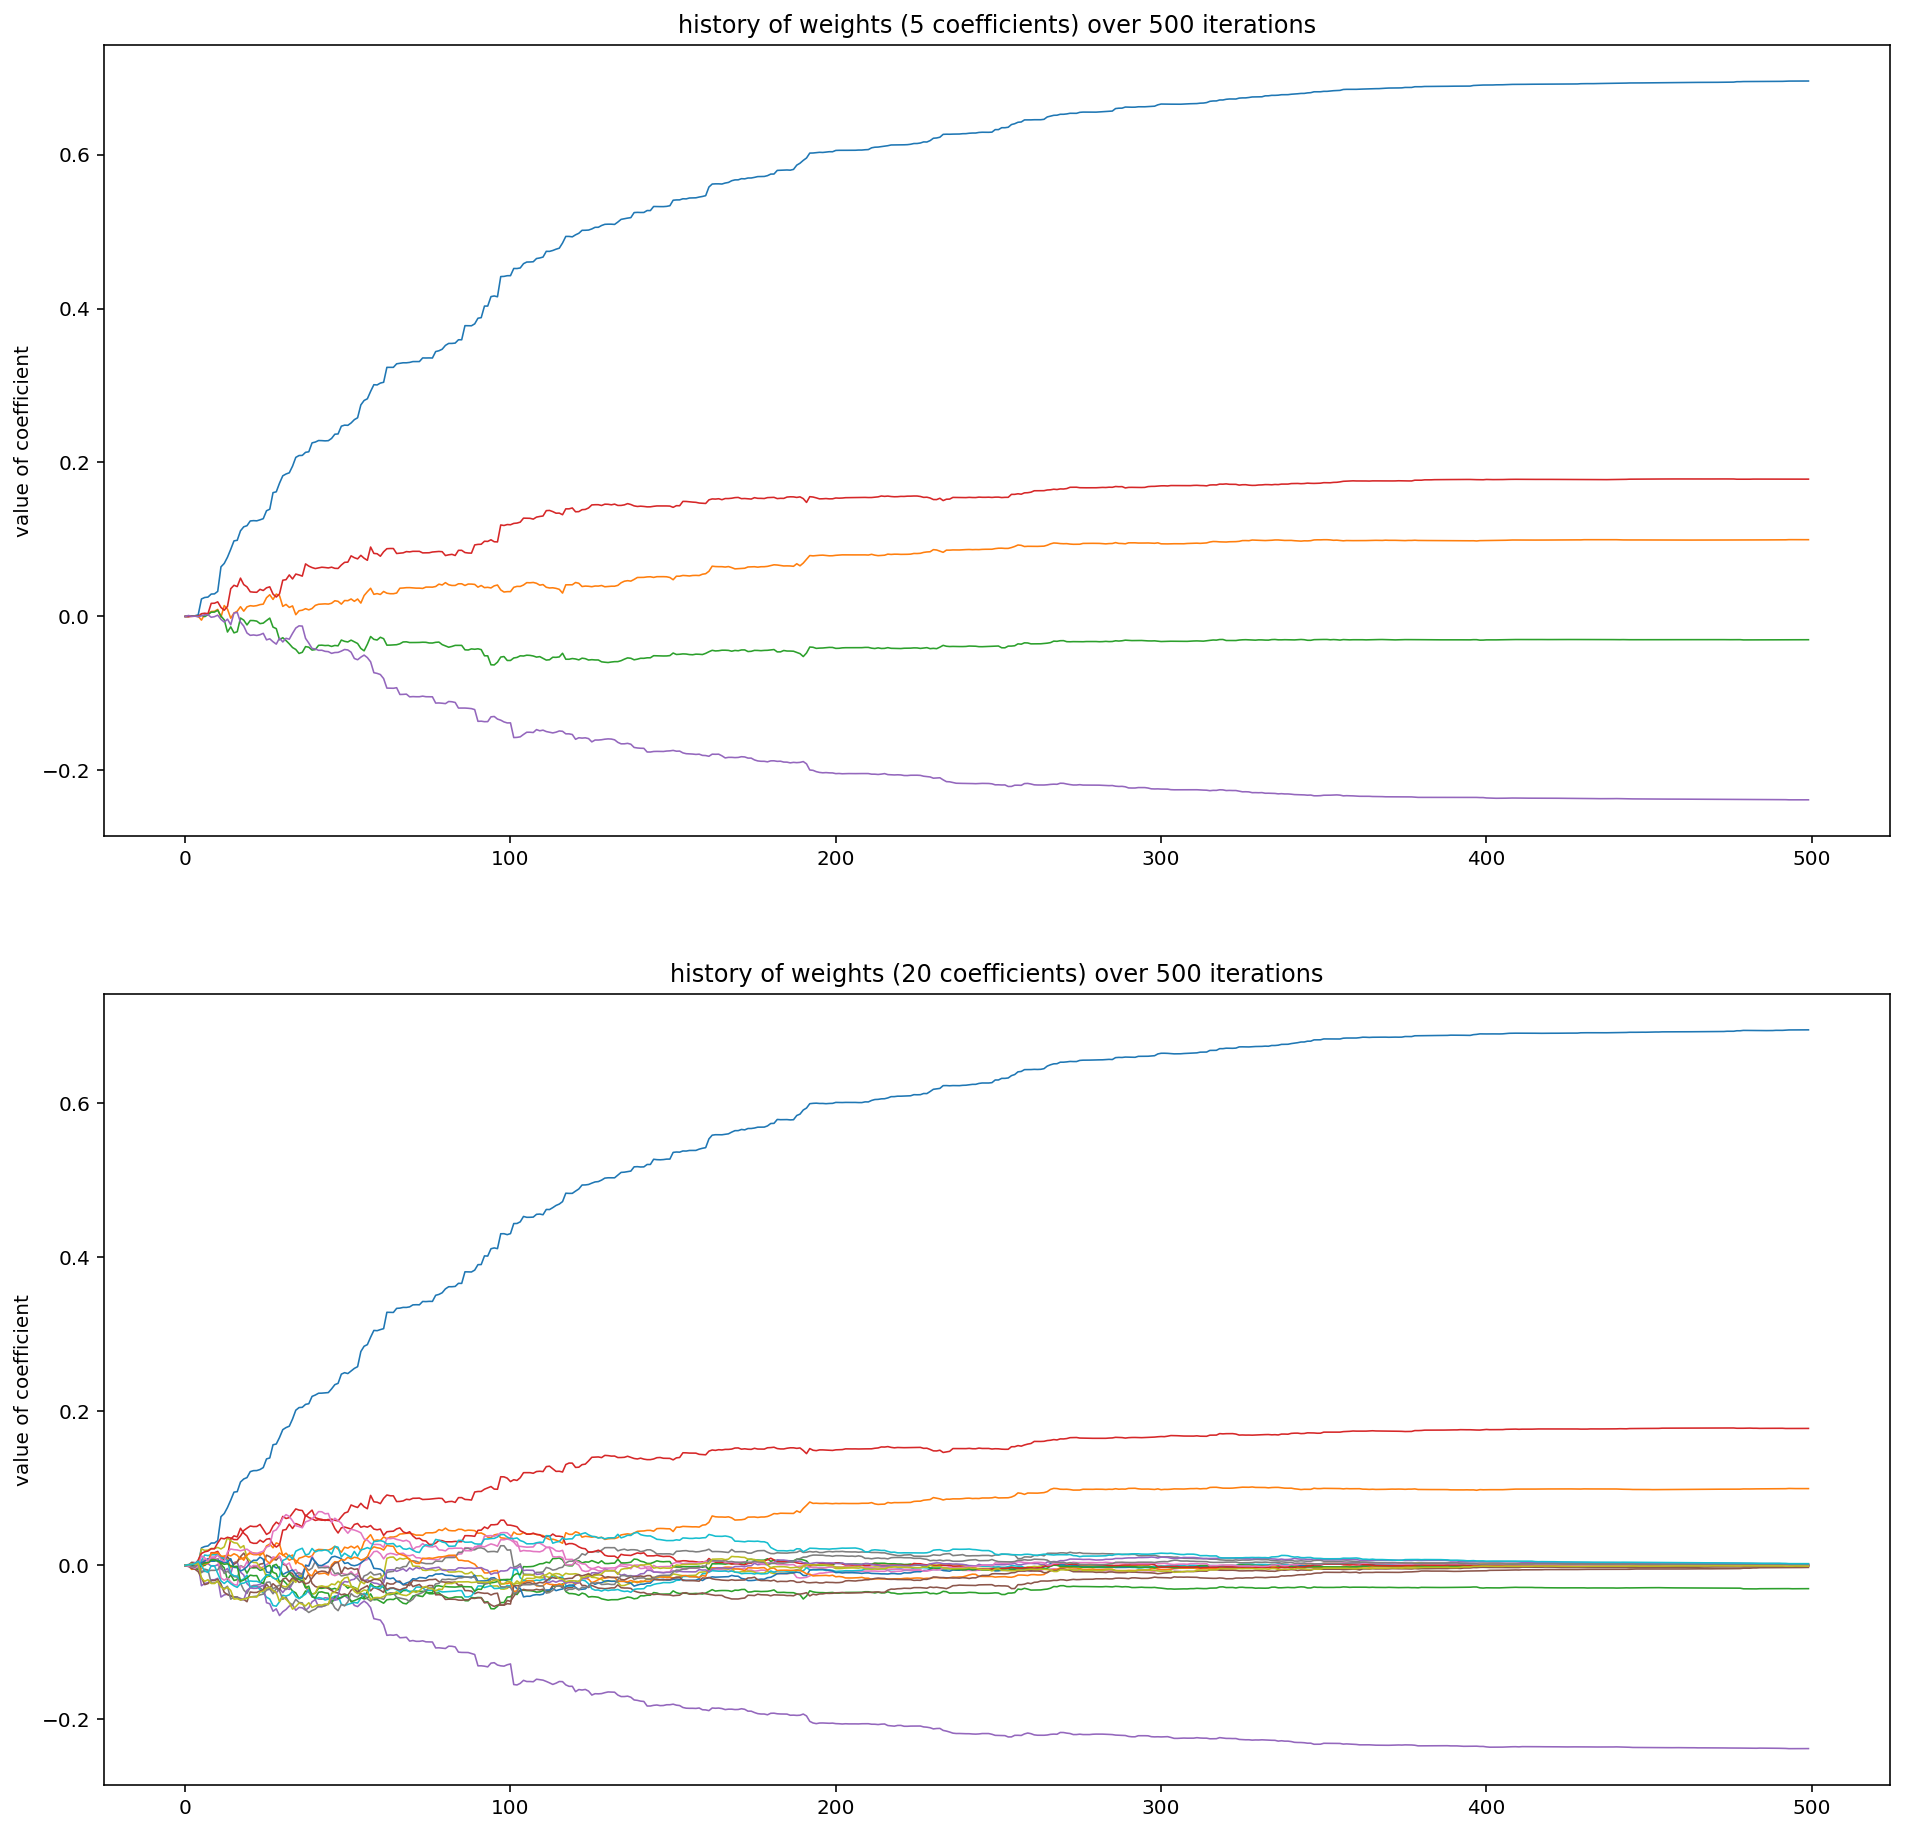

In [412]:
plt.figure(figsize=(16,16))
plt.subplot(211); plt.plot(lms(5,Dfir,Xfir)[0].T[:500],linewidth=0.8);
plt.title('history of weights (5 coefficients) over 500 iterations');
plt.ylabel('value of coefficient')
plt.subplot(212); plt.plot(lms(20,Dfir,Xfir)[0].T[:500],linewidth=0.8);
plt.title('history of weights (20 coefficients) over 500 iterations');
plt.ylabel('value of coefficient');

After some initial movement all the 15 unnecessary weights converge to 0

---

## Robustness to Noise

#### Theory

In applications of the algorithms discussed here we often face measurement impurities that interfere with our task of system identification. We can simulate these measurement impurities with gaussian noise and observe the behavior of the algorithms. We choose a geometrical approach to conceive our expectations on influence of noise. For visualisation purposes we will consider the case of $N=2$ coefficients. Inlcuding the error as another dimension we get a three dimensional figure.

![Figure 4](AF2018/noise_err.png)

$$\hat{d}[k] = w_1x[k] + w_2x[k]$$

As $\hat{d}$ is a linear combination of the input vectors, all estimates will have to lie on the surface that is spanned by the signals $x[k]$ and $x[k-1]$. The optimal estimate $\hat{d}[k]$ of the desired signal $d[k]$ therefore is a projection of $d[k]$ onto the this surface. Accordingly the error signal $e[k]$ will be orthogonal to the surface. 
As the noise we will add is supposed to be uncorrelated to the signal it will also be orthogonal by definition. Geometrically speaking an additional noise will lead to a longer distance that a projection of $d[k]$ has to travel until hitting the surface (resulting in $\hat{d}[k]$). This brings us to the expectation of a positive linear dependence between signal noise variance and squared expectation error. 

Regarding any differences between the algorithms we suppose that the RLS will have an advantage because of the recursive term. The recursive term helps in that it has a (with $\rho=1$ infinit) memory of previous states. Noise with zero mean could lose some of it's significance as it will be canceled in the mean over time.

#### Simulation

We will introduce an increasing amount of noise into the desired signal. Starting from a rather low $\sigma = 0.001$ we will go to an amount of $\sigma = 10$ which exceeds the signal power by a factor of 10. Given such a weak signal to noise ration (1 to 10) it can seem questionable whether the task of system identification is probably ill posed then. The just discussed theory however tells us, that there is a good chance of finding the right coefficients if the noise is truly uncorrelated. In that case the distance that the projection has to travel is a lot further, but the orthogonal point it will result in will not change much. 

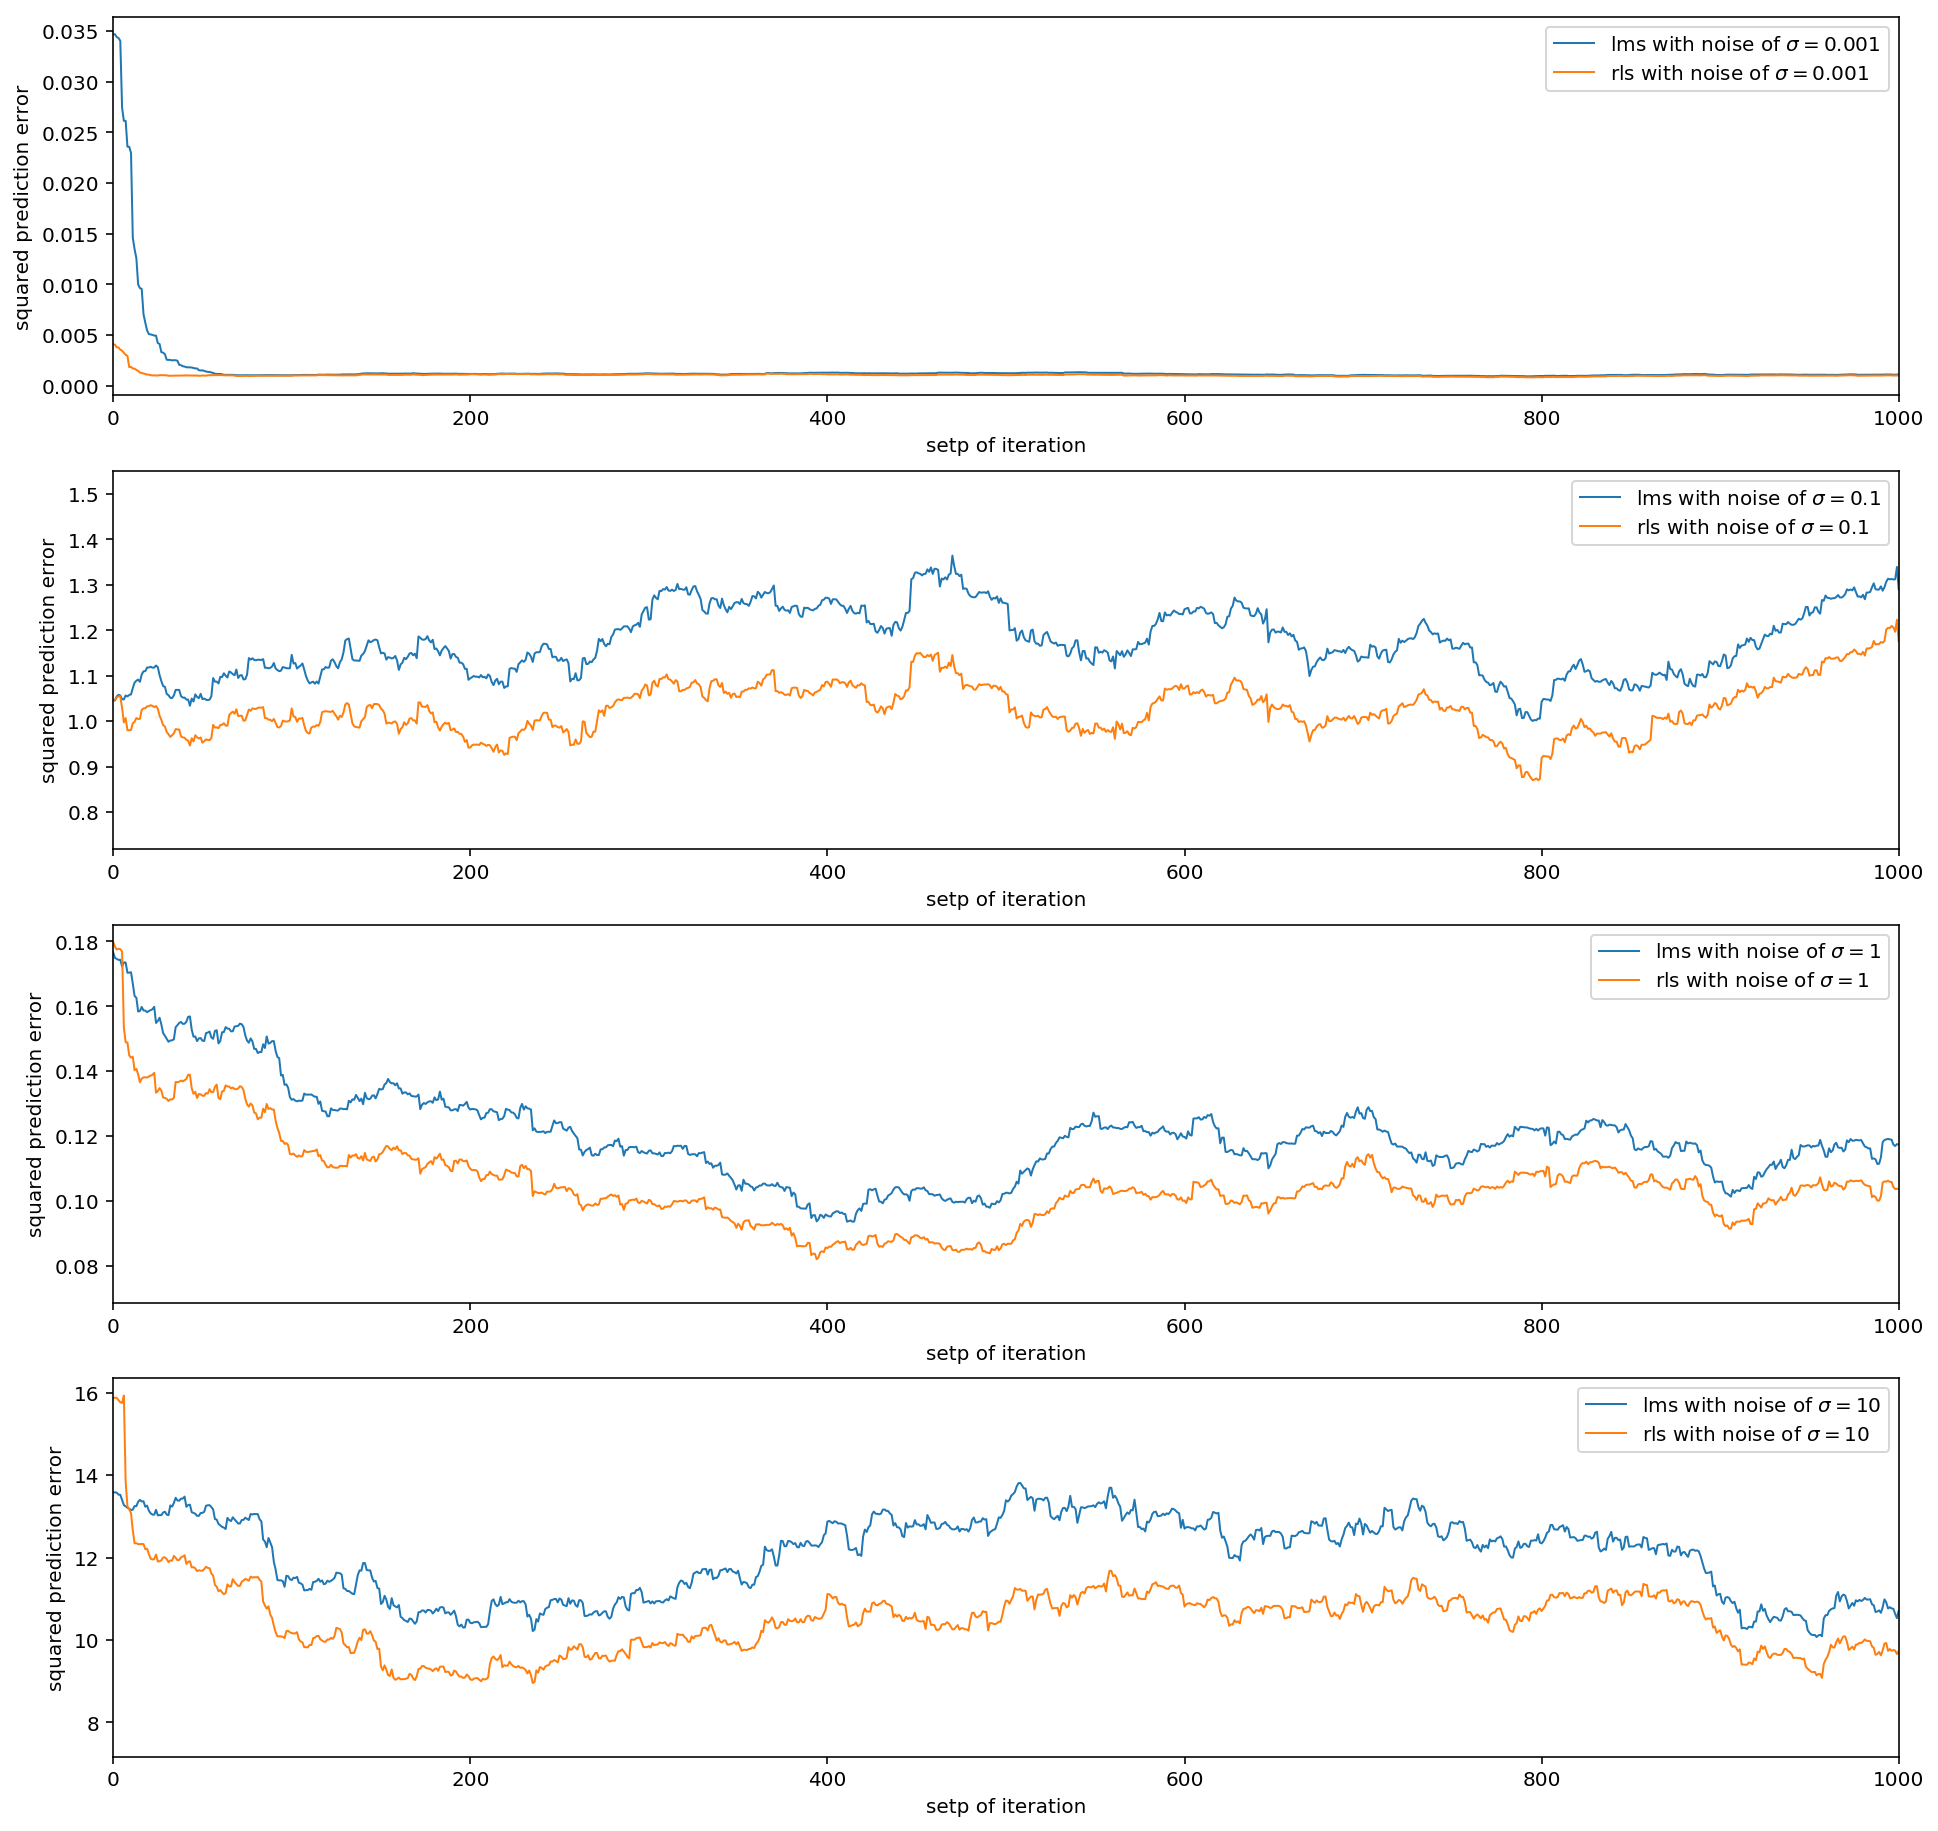

In [413]:
DfirN01,DfirN1,DfirN10=addnoise(Dfir,1),addnoise(Dfir,0.1),addnoise(Dfir,10)
pltmax = 1000; mu = 0.05

plt.figure(figsize=(16,16))
plt.subplot(411); plt.xlim(0,pltmax)
plot(lms(5,DfirN0001,Xfir,mu)[1],'lms with noise of $\sigma=0.001$')
plot(rls(5,DfirN0001,Xfir)[1],'rls with noise of $\sigma=0.001$')
plt.subplot(412); plt.xlim(0,pltmax)
plot(lms(5,DfirN01,Xfir,mu)[1],'lms with noise of $\sigma=0.1$')
plot(rls(5,DfirN01,Xfir)[1],'rls with noise of $\sigma=0.1$')
plt.subplot(413); plt.xlim(0,pltmax)
plot(lms(5,DfirN1,Xfir,mu)[1],'lms with noise of $\sigma=1$')
plot(rls(5,DfirN1,Xfir)[1],'rls with noise of $\sigma=1$')
plt.subplot(414); plt.xlim(0,pltmax)
plot(lms(5,DfirN10,Xfir,mu)[1],'lms with noise of $\sigma=10$')
plot(rls(5,DfirN10,Xfir)[1],'rls with noise of $\sigma=10$')

We notice that with an increase of noise variance $\sigma$ of a factor of 10, the squared error increases by a similar amount. Our expectations regarding the linear dependency of noise level and prediction error can be confirmed by our experiment. Comparing the algorithms we can see that RLS is robuster to noise and outperforms the LMS in all cases. Finally to get an impression of how close our best algirhtm (RLS) found the coefficients on the most noisy task let us compare the final filter wights with the solution

In [414]:
rls(5,DfirN10,Xfir)[0][:,-1], Hfir

(array([ 0.77993373,  0.05079189, -0.04593404,  0.18256959, -0.24925342]),
 array([ 0.7 ,  0.1 , -0.03,  0.18, -0.24]))

taking the differen

In [415]:
rls(5,DfirN10,Xfir)[0][:,-1] - Hfir

array([ 0.07993373, -0.04920811, -0.01593404,  0.00256959, -0.00925342])

In fact we can see that still the algorithm comes close to the desired coefficients with only missing it by approximately $0.02$

---

## Effect of Learning Rate in Lms

#### Theory

While RMS does not depend on any metaparameters in LMS we have to adjust the learning rate $\mu$. Useful values lie in the interval of $0 < \mu < \frac{2}{\lambda_{max}}$. With $\lambda_{max}$ beeing the maximum eigenvalue of the auto-correlation matrix of the input signal $R = E\{\underline{x}[k]\underline{x}^t[k]\}$. The maximum of the learning rate can intuitively be described as those cases where the learning algorithm overshoots the error surface. This is, that the step size is larger than the diamter of the hypberboloid. Therefore every movement will result in an at least slightly worse performance. As undesirable as this result is, the other extreme of small $\mu$ results in painfully slow adaptation. This happens as the weights are changed by tiny amounts only.

As $\mu_{max}$ only depends on the signal statistics of the input it seems natural to estaimte it to achieve maximum convergence speed. With some furhter considerations to get a conservative estimates of $\lambda{_max}$ by the trace of the auto correlation matrix as well as the input signal spectrum, it can be shown that the mean power of the input signal is sufficient for an approximation of $\mu_{max}$. We can therefore use the relation
$$0 = \mu = \frac{2}{N \cdot \text{(mean input power)}}$$
to get the maximum learning rate for eq. the case of $N = 5$ coefficients.

In [416]:
2/(5*(Xfir@Xfir/len(Xfir)))

0.39551018588058473

In practice this value turns out to be to big. The LMS set up with this learning rate does not converge. This is because we took the mean of the whole signal and cannot expect the input power to stay at it's mean for the whole time. Therefore it is suggested to adapt the learning rate to the input signal at every iteration which leads us to the normalized least mean squares (NLMS) algorithm. Our implementation can easily be changed to the NLMS by substituting $$\mu = \frac{\beta}{\gamma + \underline{x}^t[k]\underline{x}[k]}$$
with $0<\beta<2$ and $\gamma$ beeing a small positive security constant, preventing $\mu[k]$ to become very large.

To get an insight into the dynamics of the learning rate it is beneficial to take a look without the automatic normalization. In particular one crucial point to be shown that way is the dependency between the misadjustment and learning rate. The misadjustment is a function of $\mu$ as
$$M = \frac{\mu}{2}\cdot N \cdot (\text{input power})$$
We can expect that with a high learning rate $\mu$ there will be a fast convergence but also a higher squared error in the region of convergence.

#### Simulation

Values for $\mu$ were chosen to show the effect clearly, there are however many cases where the benefit of a smaller misadjustment seems less pronounced. 

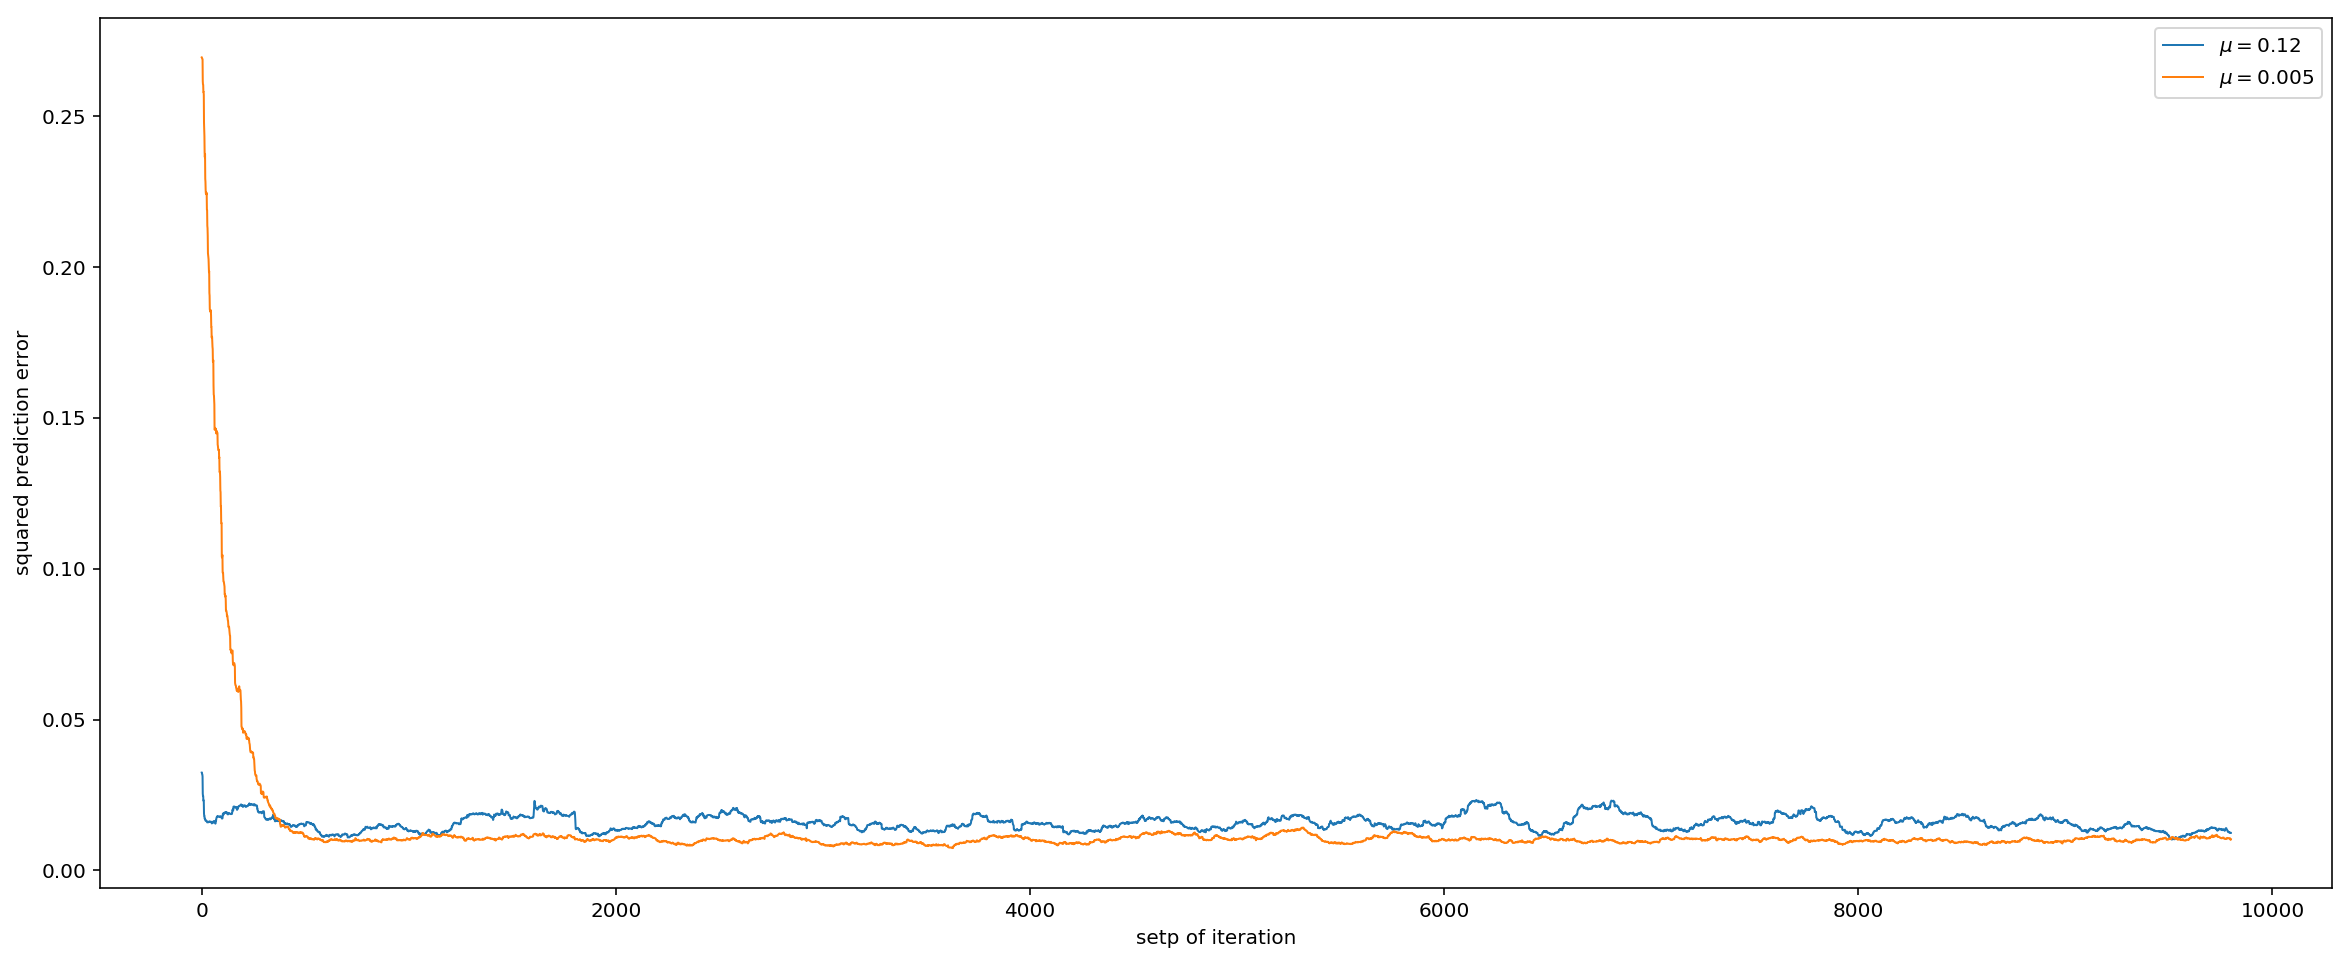

In [417]:
plot(lms(5,addnoise(Dfir,0.01),Xfir,0.12)[1],'$\mu=0.12$');
plot(lms(5,addnoise(Dfir,0.01),Xfir,0.005)[1],'$\mu=0.005$');

The error of the LMS with a bigger step size is not only higher but also has higher variance.

---

---

# IIR System Identification

## Given IIR Filter

## Load Given Data

In [418]:
IIR = sio.loadmat('AF2018/System_IIR3.mat') # load provided data
Xiir = IIR['X'][0].astype('float64') # input signal
Diir = IIR['D_'][0][0:10000].astype('float64') # desired signal

---

## Comparison of Number of Coefficients

### Theory

Our implementations of adaptive filters are based on a FIR model. The advantage in opposition to IIR model is that we do not have to consider instable behaviour that can result in IIR systems because of poles outside the unit circle. It can happen in practice however that the system we would like to model has recursive terms.

If we want to reconstruct an IIR filter by an FIR filter we would need an infinite number of coeffitients. A good approximation will therefore need as many coeffitients as we can get. Considering the general tendency of the effect of truncating coefficients we can rely on the distinction of three cases. Unstable IIR filters will in essence not be possible to approximate, because the feedback is what drives them to infinit valued response, it is not BIBO. For marginal stable IIR Filters the impulse response will infinitly osciallate, and we would indeed need an infinit number of FIR coefficients. For stable IIR Filter however we know that the impulse response is decaying and therefore, in average the later a coefficient is the closer it will be to 0. We can therefore assume that in avearge later coefficients will have less impact which backs our approach of a truncation. 

In the simulation we schould see an increase of prediction accuracy with an increase of coefficients that are at disposal. This effect will be stronger in the beginning and decay exponentially. In contrast to the only 2 recursion coefficients that are needed to describe the IIR Filter completely the FIR filter is expected to need many more.
We do not expect any additional differences between RLS and LMS other than numerical inaccuracies.

### Simulation

We first test the LMS with an increasing number of coefficients and a minimum noise.

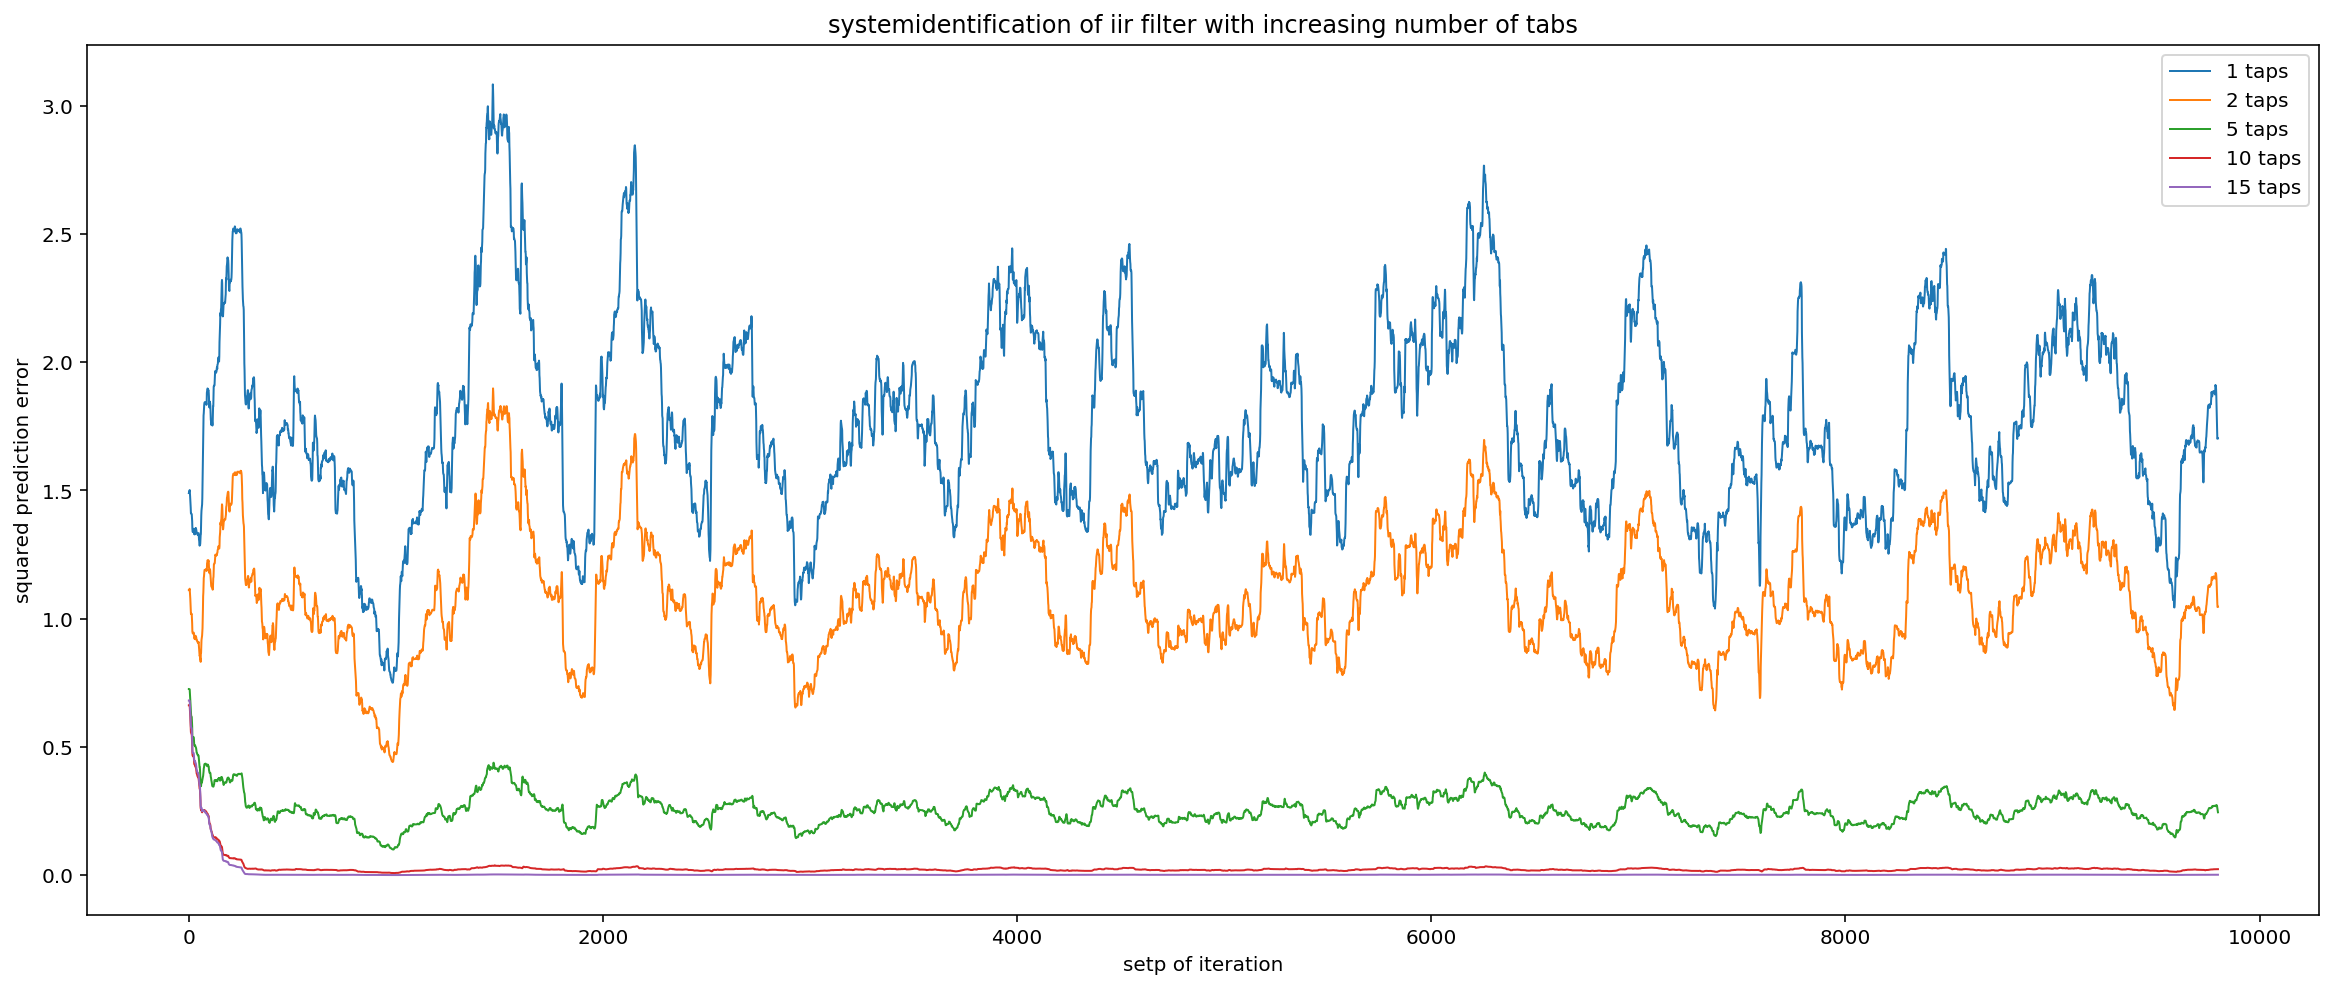

In [419]:
for taps in [1,2,5,10,15]:
    plot(lms(taps,addnoise(Diir,0.0001),Xiir)[1],str(taps)+' taps') 
plt.title('systemidentification of iir filter with increasing number of tabs');

<center>Figure 7</center>

As expected we see that increasing the number of coefficients yields a bigger performance improvement in the beginning (for 1 to 2 to 5 coefficients) and loses it's impact after a while (almost no improvement from 10 to 15 coefficients)

We now compare the performance of LMS to RLS in the 5 coefficient case that should be roughly the same (except for the convergence speed discussed in the previous chapter)

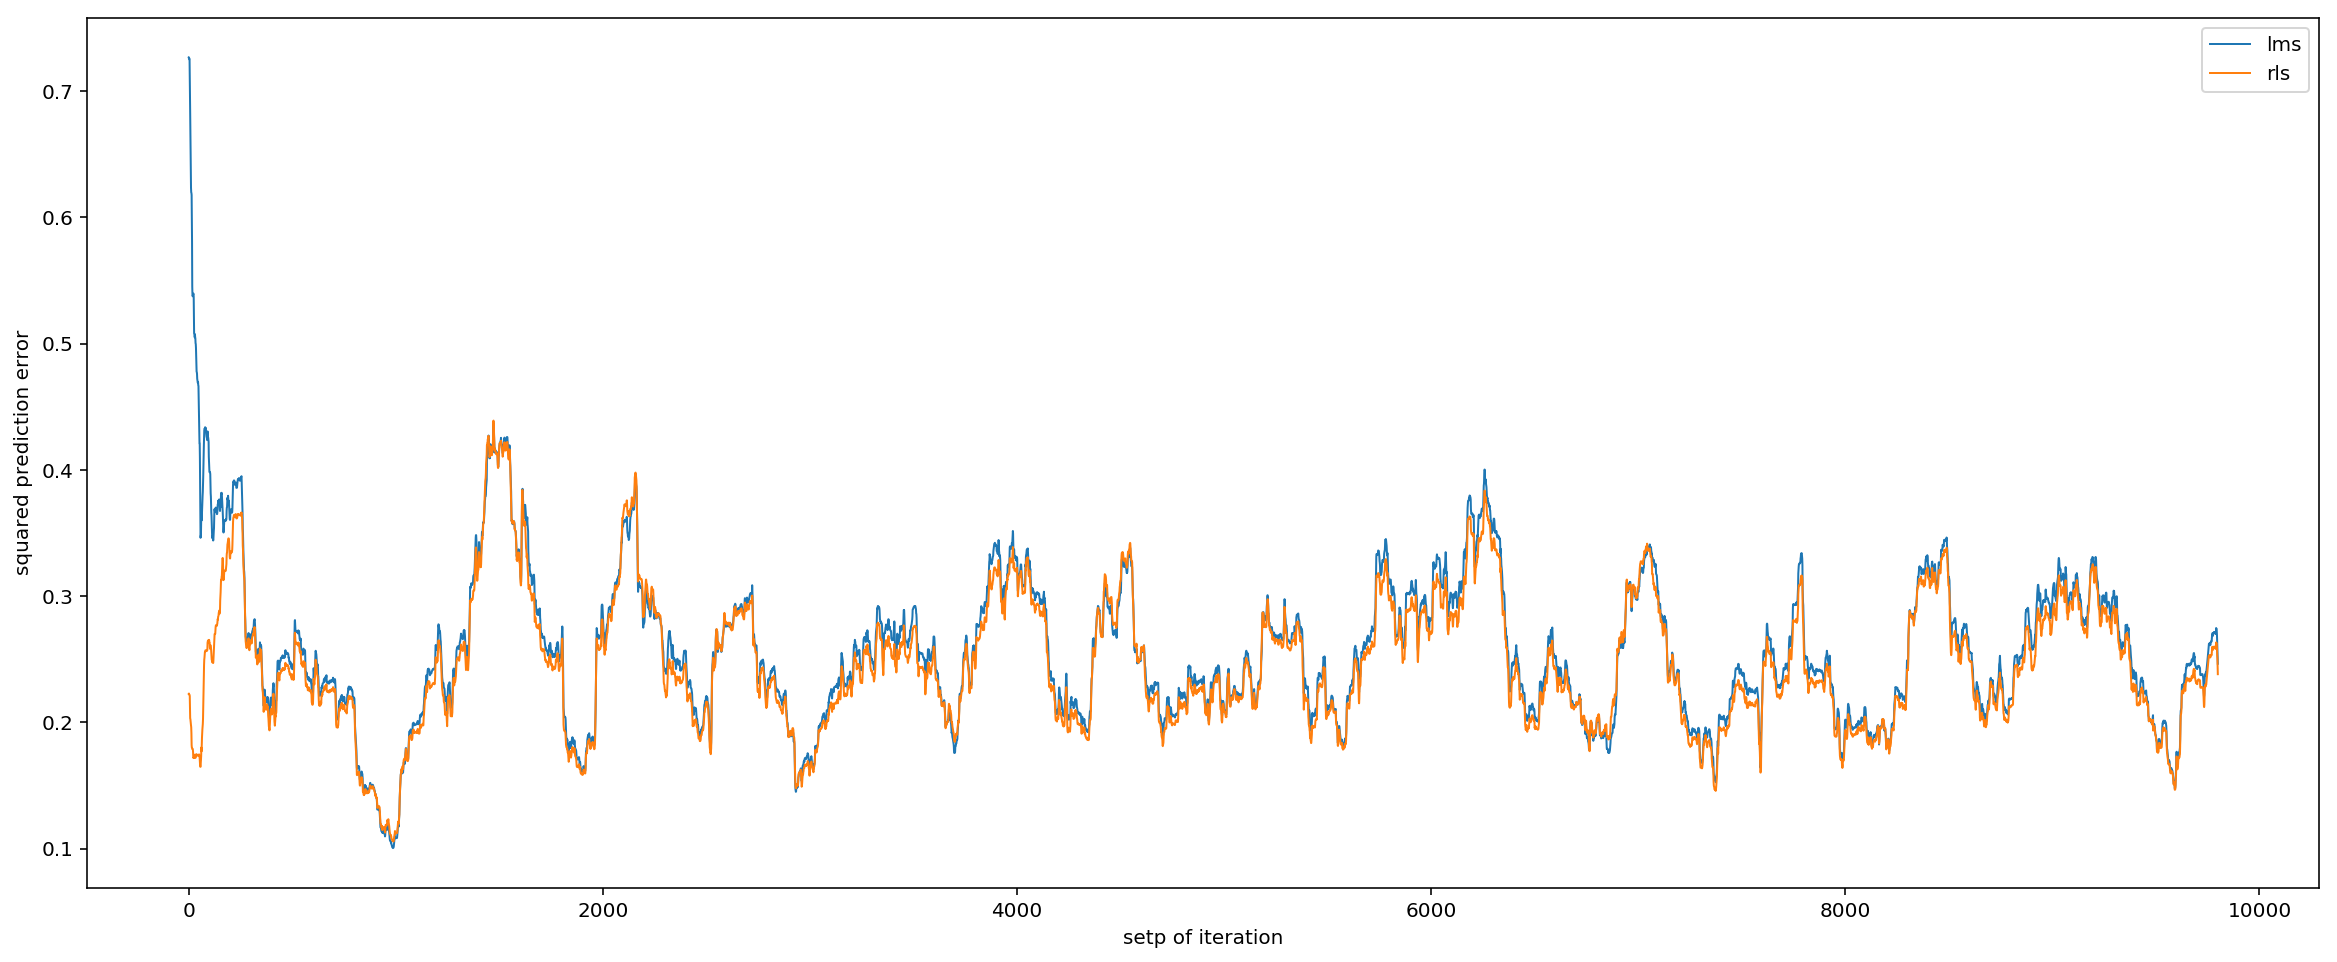

In [420]:
plot(lms(5,Diir,Xiir)[1],'lms'); plot(rls(5,Diir,Xiir)[1],'rls');

<center>Figure 8</center>

LMS and RLS yield comparable results.

---

# System Change

## Load Given Data

In [421]:
# load provided data
FIRx = sio.loadmat('AF2018/Systemwechsel_FIR3.mat')
IIRx = sio.loadmat('AF2018/Systemwechsel_IIR3.mat')
# input signal
Xfirx = FIRx['X'][0].astype('float64')
Xiirx = IIRx['X'][0].astype('float64')
# desired signal
Dfirx = FIRx['D_'][0][0:10000].astype('float64')
Diirx = IIRx['D_'][0][0:10000].astype('float64')

## Forgetting Factor

### Theory

By observing a system change we can evaluate the tracking capabilities of the algorithms. That is, how quickly it can adjust to changes in the system once it converged to a quasi stationary state. Convergence speed and tracking a closely related in that both describe how quick convergence is achieved. The key difference lies in additional inclusion of the previous state. This can be seen for the RLS where we initialize the filter with a huge $\eta$ (on the diagonal of the $\mathfrak{R}_k^{-1}$ in order to make it converge quick. Over the course of adaptation the matrix $\mathfrak{R}_k^{-1}$ will however change and the longer the history the less flexible it will become to new values. It seems reasonable to start with an examination of the forgetting factor. If we start with a forgetting factor $\rho = 1$ we therefor expect the slowest tracking capability. For the matter of a fast tracking we want $\rho$ to be small, but again this tuning of a meta parameter becomes a trade-off. In the last chapter we saw, that the increased robust of the RLS to noise is was due to the recursive term averaging out white gaussian noise. If we now reduce the scope of this recursive term by diminishing the learning rate we remove the advantage of stabalization.

### Simulation

We will take RLS and feed instatiate versions with decreasing forgetting factor $\rho$. Also a small amount of noise was induced to examine the dependence of the nosie robustness to the forgetting factor. We decided on the FIR system change as the identification is cleaner in the sense that we do not have to consider truncation errors of approximating an IIR system. 

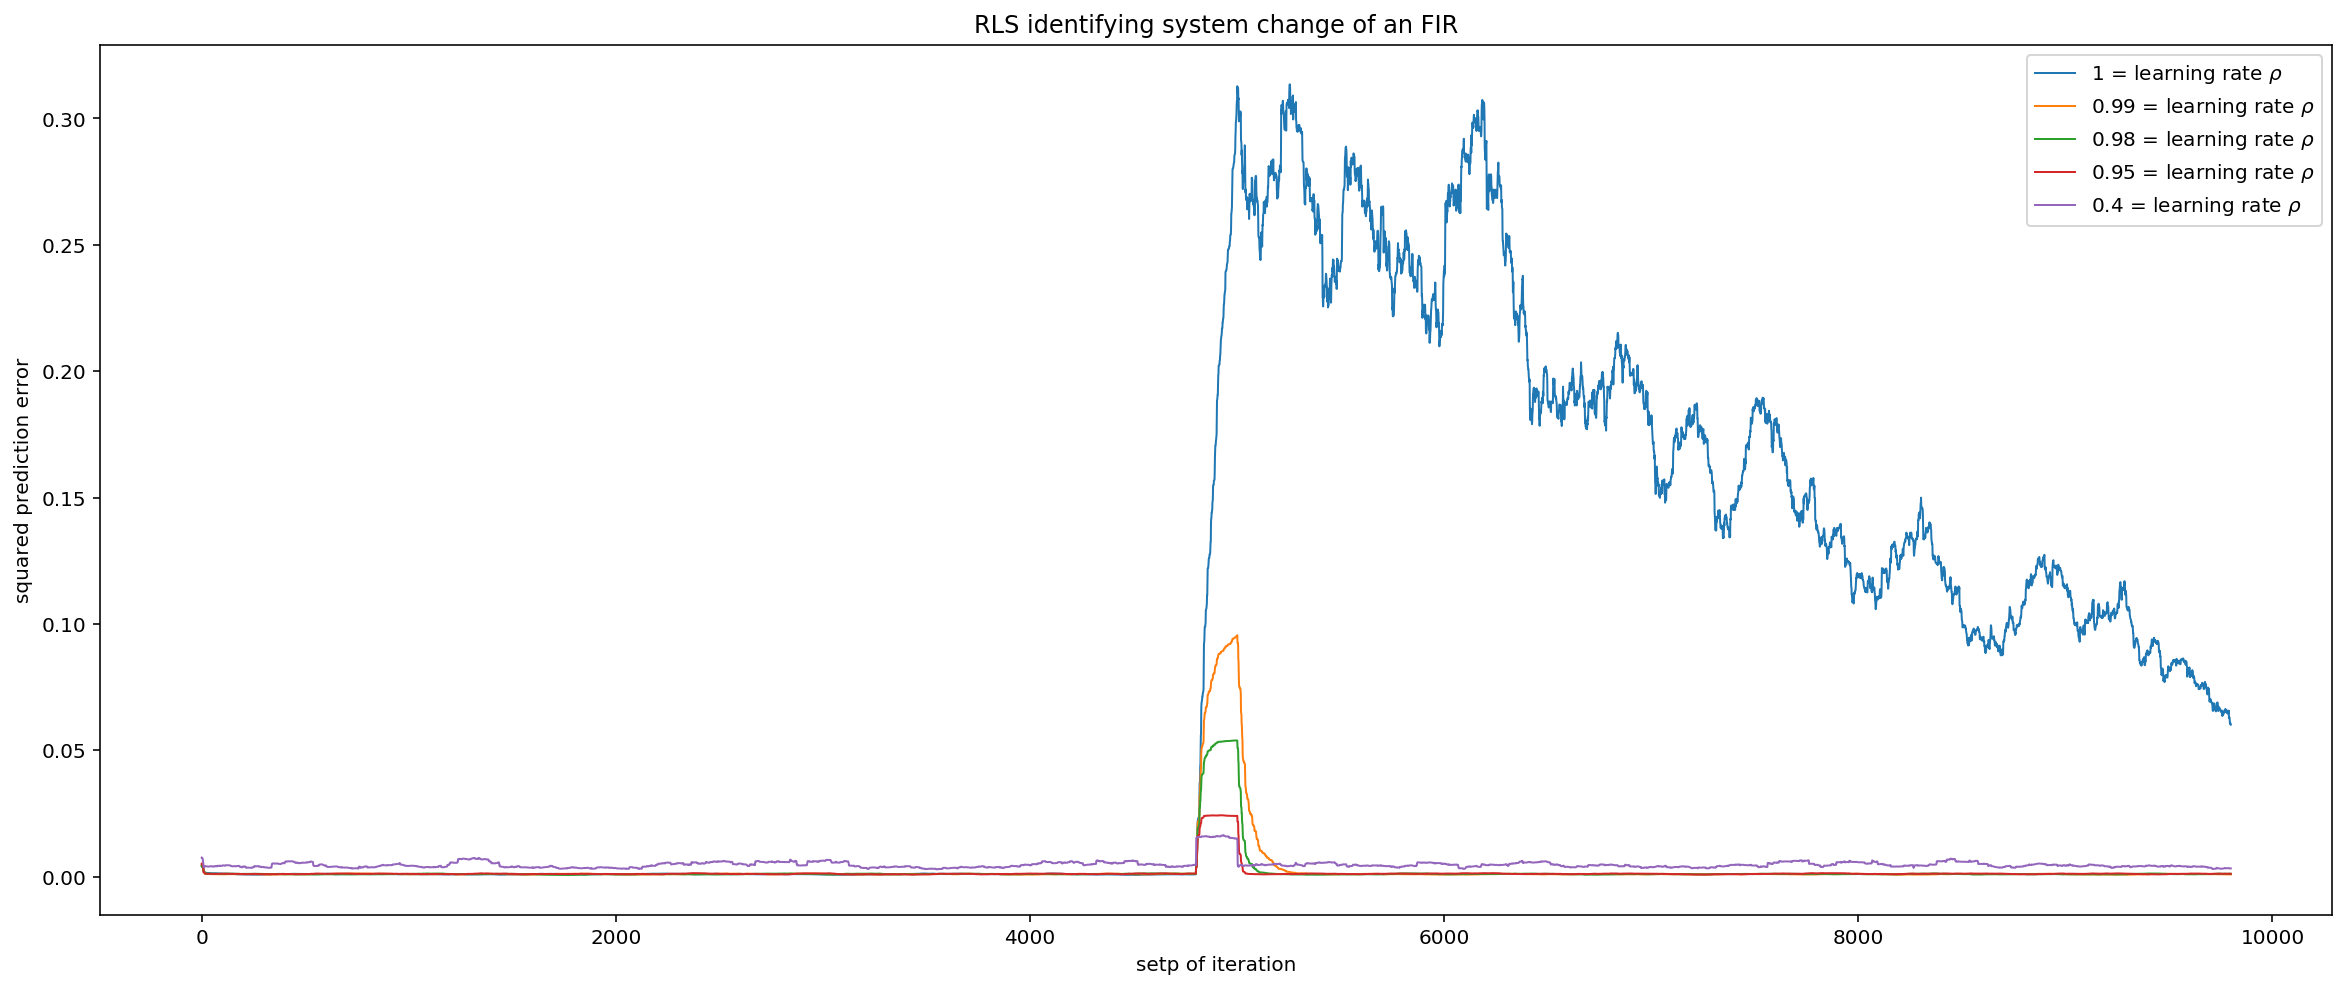

In [422]:
for rho in [1,0.99,0.98,0.95,0.4]:
    error = rls(5,addnoise(Dfirx,0.001),Xfirx,rho)[1]
    plot(error,str(rho)+' = learning rate $\\rho$')
plt.title('RLS identifying system change of an FIR');

As we anticipated the learning rate should be less than 1 as soon as an application demands any kind of tracking. A small change from $1$ to $0.99$ already yields a great increase. For small learning rates as for example $\rho = 0.4$ we can confirm reduced robustness to noise. 

## Comparison of number of coeffitients 

### Theory

Assuming that the systems merely change their coefficients we do not expect any different behaviour than from what was statet in the previous chapters. That is, as soon as a sufficient number of coefficients was met, there will be no further improvement by increasing the number of coefficients. Differences in the error before and after the system change could appear in the case of less than sufficient coefficients. This is due to the fact that the coefficients that produce the highest variance could be later in one system than in the other, and therfore be missing.

### Simulation

We start with the FIR system change and increase the number of coefficients for the LMS and RLS case.

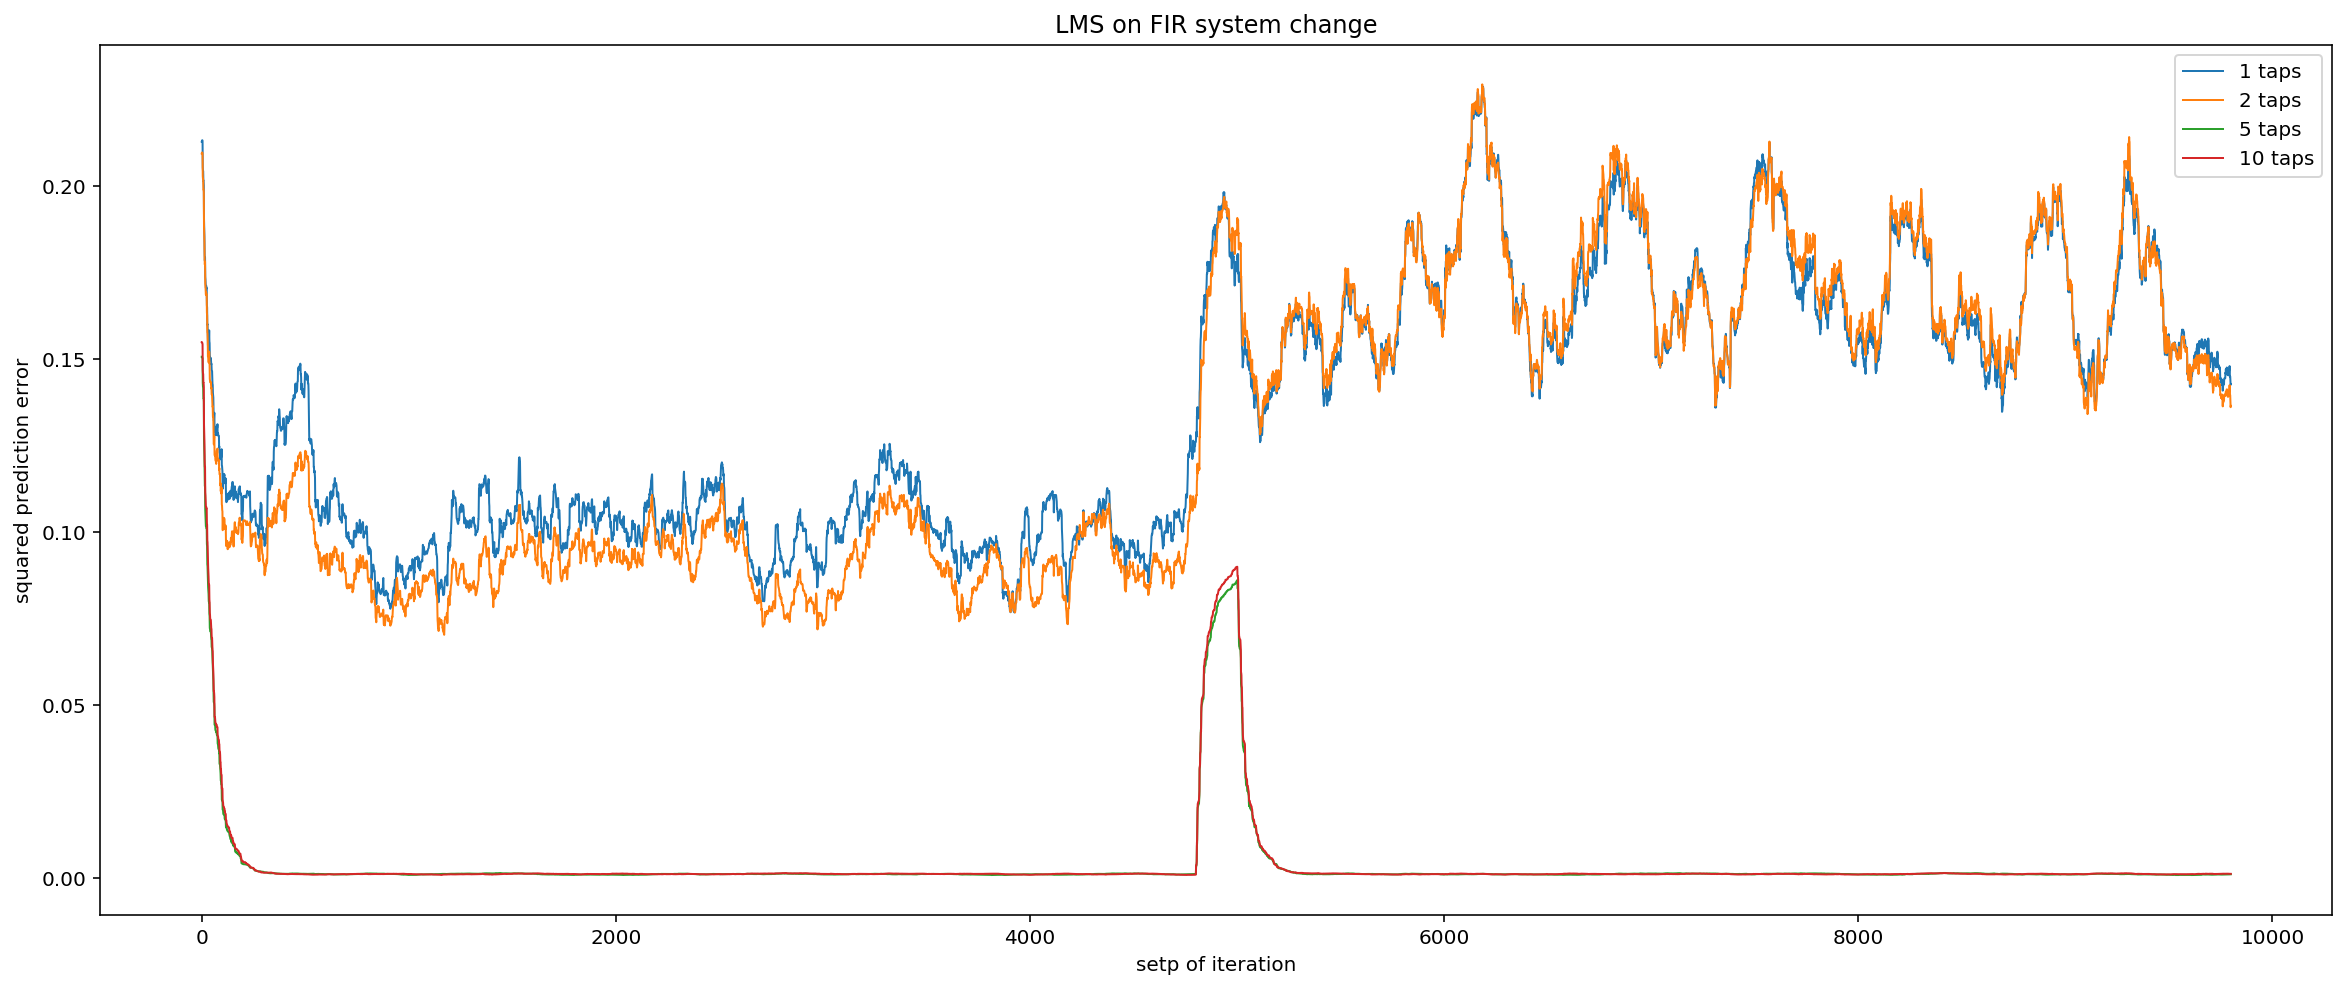

In [423]:
for taps in [1,2,5,10]:
    plot(lms(taps,addnoise(Dfirx,0.001),Xfirx)[1],str(taps)+' taps') 
plt.title('LMS on FIR system change');

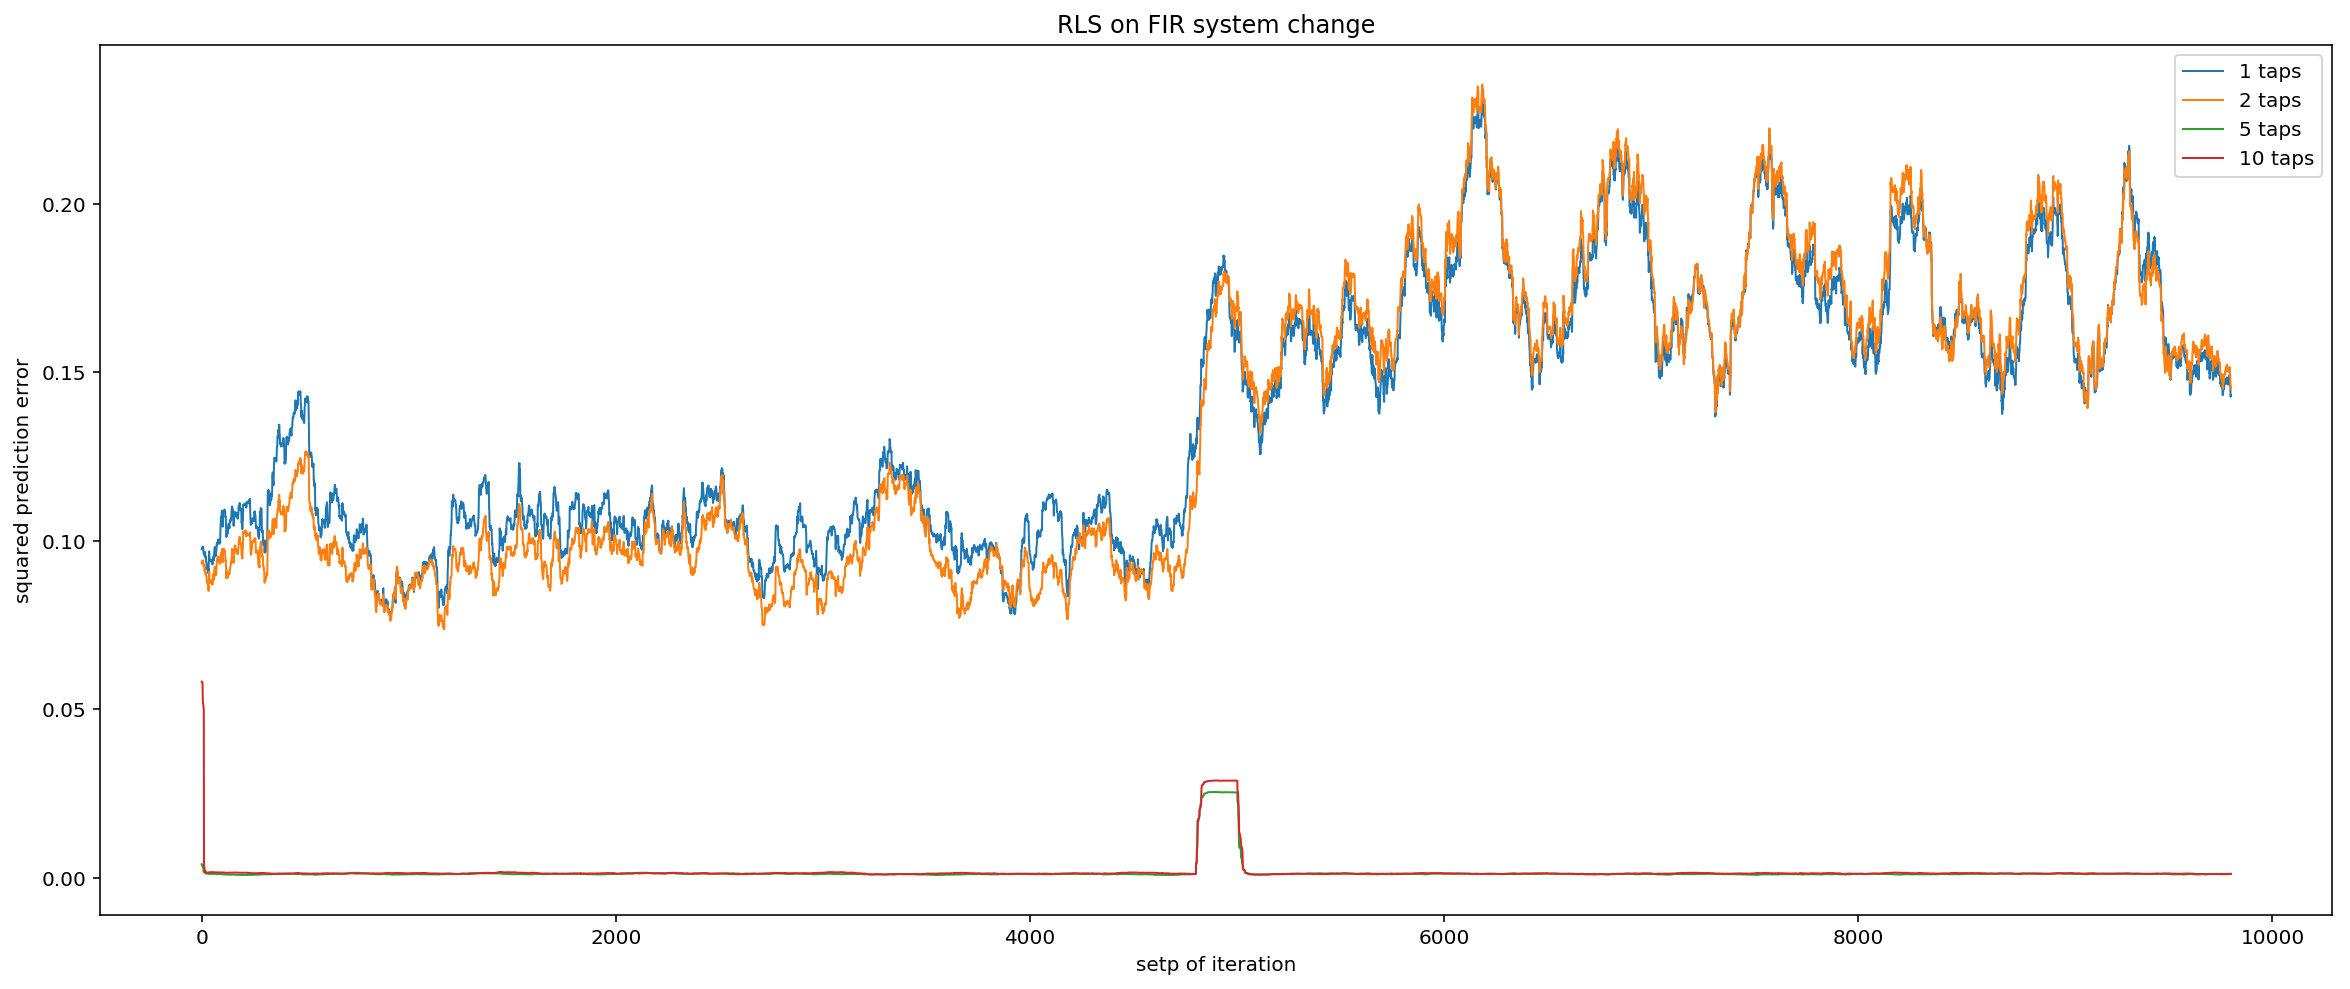

In [424]:
for taps in [1,2,5,10]:
    plot(rls(taps,addnoise(Dfirx,0.001),Xfirx,0.95)[1],str(taps)+' taps') 
plt.title('RLS on FIR system change');

Both systems can be completely explained by five filter coefficients. The higher error values after the system change for the casess where we did not have enough filter taps give a hint towards a lower variance variance living in the first early coefficients in the second system. We now check the weight vectors at position 4000 for system one and 8000 for system two.

In [425]:
lms(5,(addnoise(Dfirx,0.001)),Xfirx)[0][:,4000]

array([ 0.70043183,  0.09881922, -0.03207024,  0.17836389, -0.2381539 ])

It appears that our first system is exactly the one we discussed in the earlier chapters.

In [426]:
lms(5,(addnoise(Dfirx,0.001)),Xfirx)[0][:,8000]

array([ 0.40068633, -0.00938325,  0.30109324, -0.17851427, -0.20166291])

Comparing the distribution of the magnitudes of the weights it becomes clear that the second system indeed has a lower variance living in the first coefficient. This explains why the our approximation with 1 or 2 taps yields a higher error on the second system than on the first.

We continue with the IIR system change in the same manner

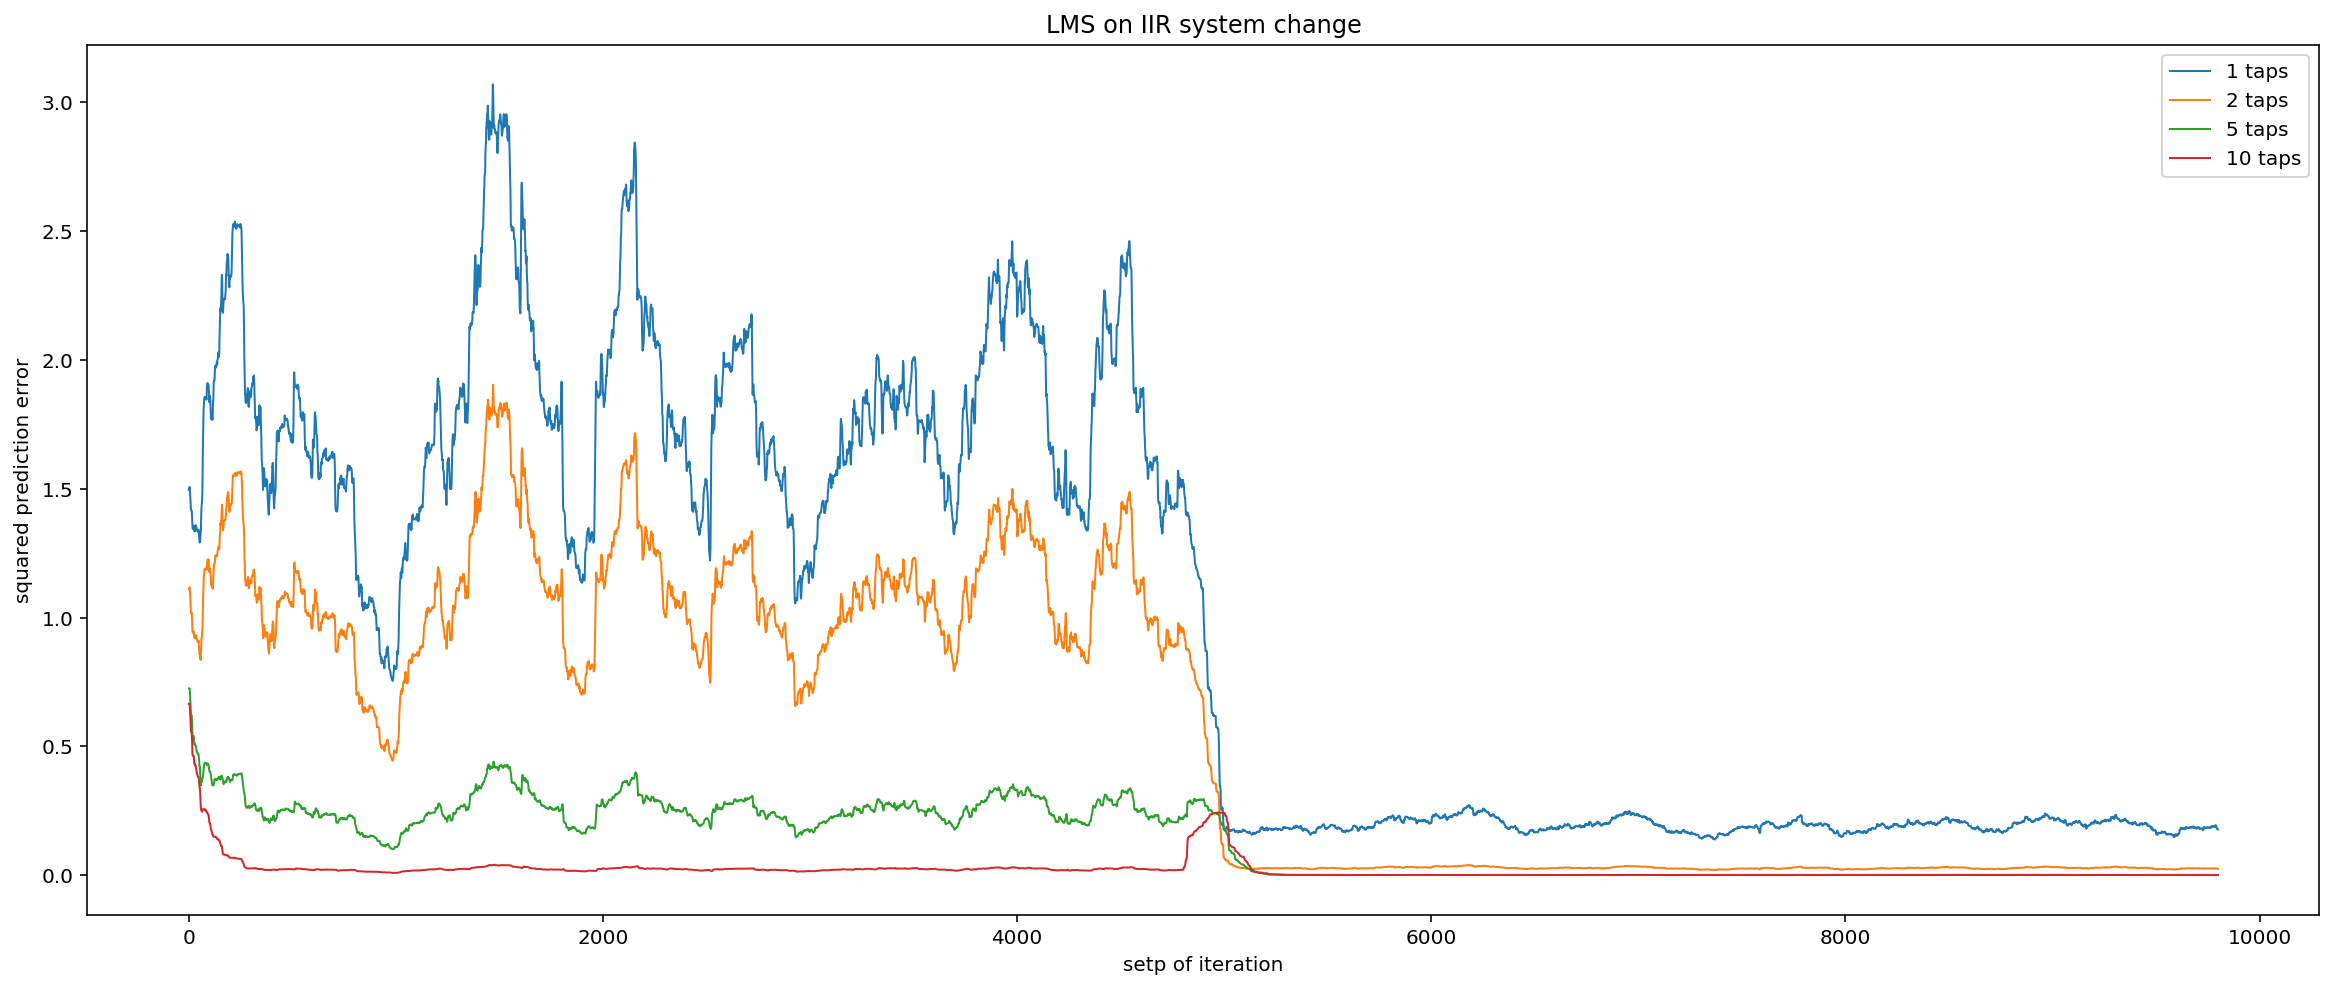

In [427]:
for taps in [1,2,5,10]:
    plot(lms(taps,addnoise(Diirx,0.001),Xiirx)[1],str(taps)+' taps') 
plt.title('LMS on IIR system change');

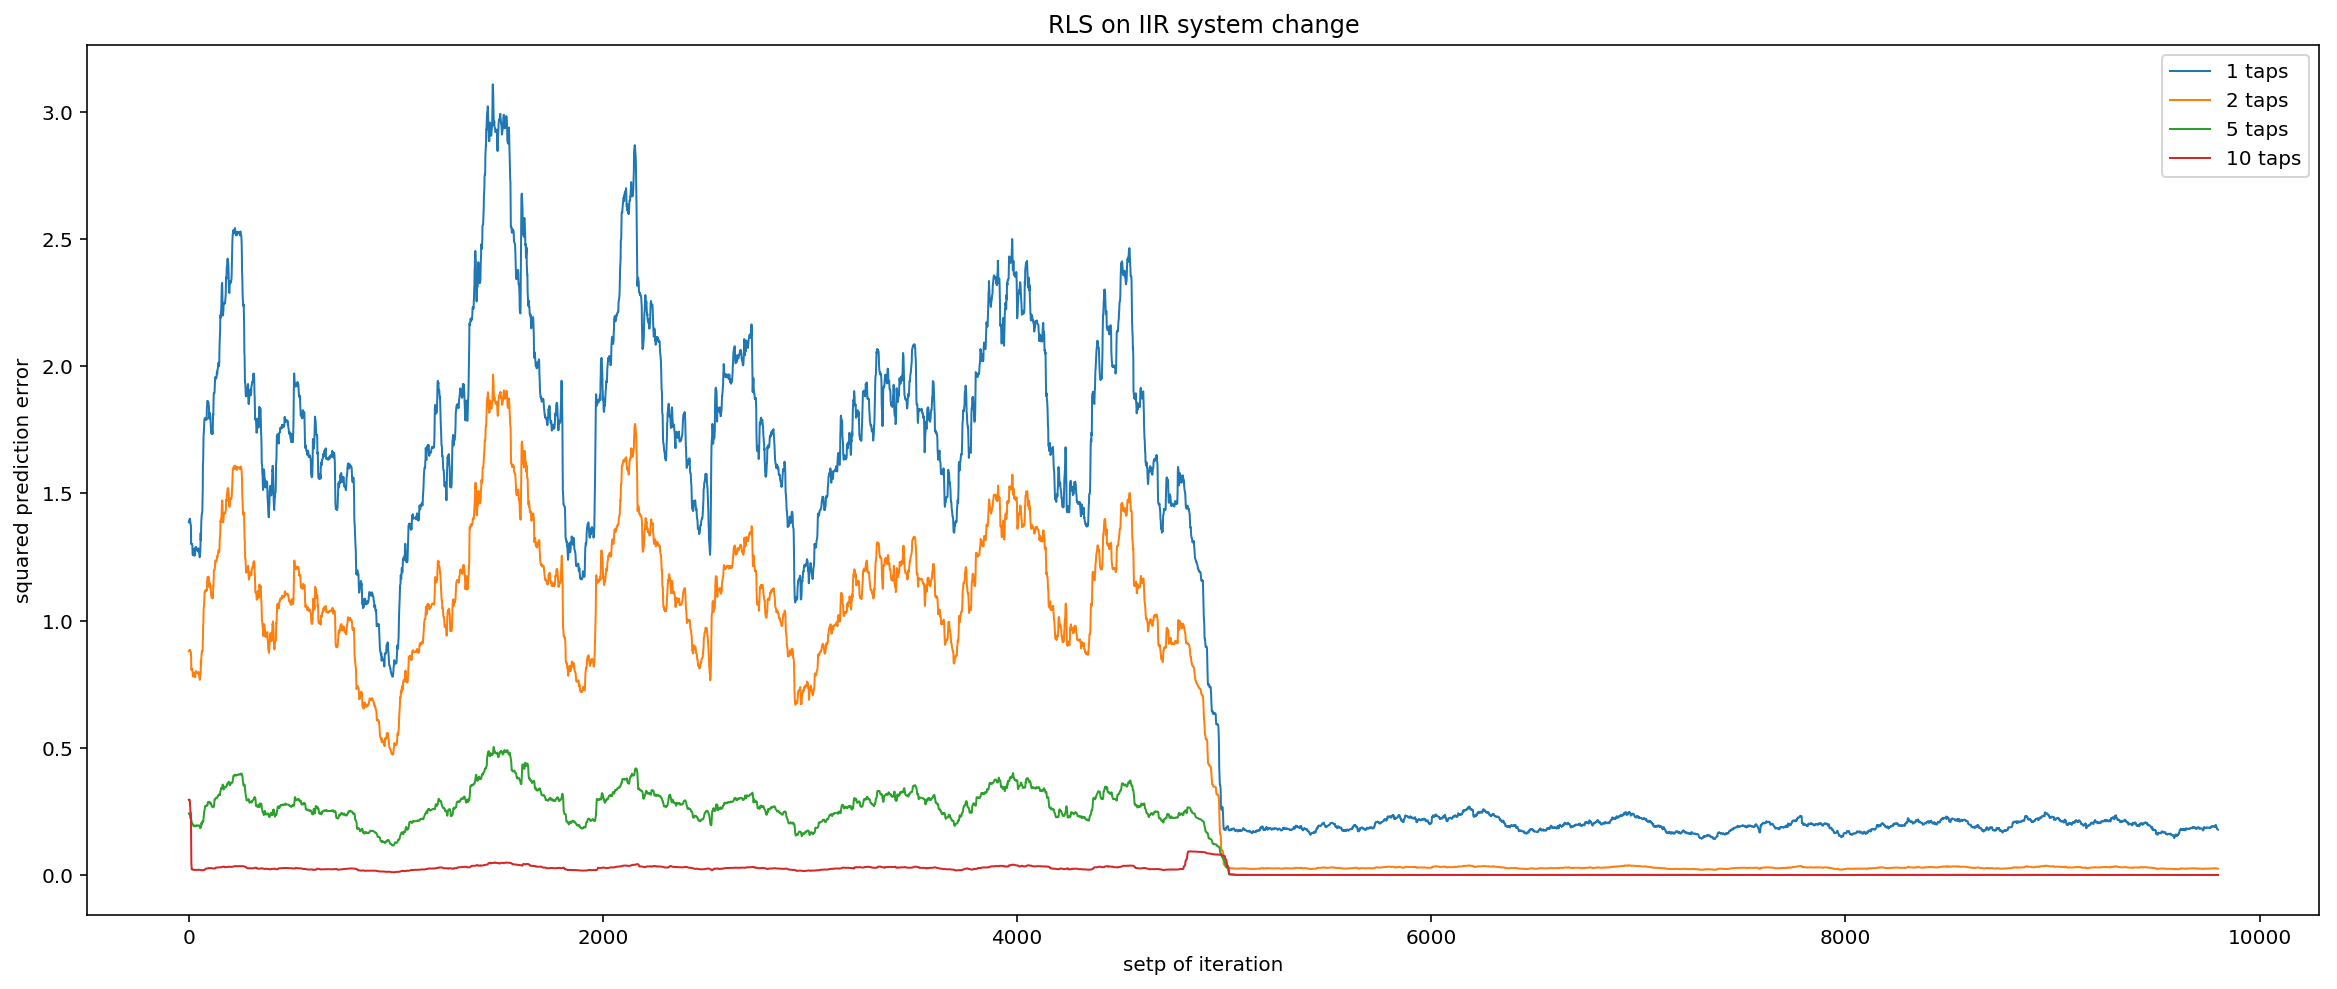

In [428]:
for taps in [1,2,5,10]:
    plot(rls(taps,addnoise(Diirx,0.001),Xiirx,0.95)[1],str(taps)+' taps') 
plt.title('RLS on IIR system change');

Now this is a surprising result! Contrary to our initial supposition this behaviour can not be explained by a mere change of filter coefficients. The second system can be approximated by five FIR filter coefficients quite well. The system change therefore is not only a change of the magnitude of coefficients or number of coefficients, it is a change of the complete filter type. Let us see the coefficients of the FIR filter that represents the second system.

In [429]:
lms(5,(addnoise(Diirx,0.001)),Xiirx)[0][:,8000]

array([0.9994981 , 0.40232818, 0.15083712, 0.06056306, 0.02130022])

## Robustnes to noise

The influence of noise shows the same dynamics as discussed in the previous chapter.

## Conclusion of LMS vs RLS

As we saw both algorithms perform robust system identification. Besides all tested influences there are other factors that differentiate them in practice, too. 

These are mainly, that the RLS is more costly to compute and harder to implement. In the application of mobile computing for example where devices run on battery, computational cost is a rigorous design choice. For LMS we have a computationl cost of $O(N)$ whereas the RLS is $O(N^2)$. On a side note the fast RLS should also be mentioned as it can reduces these costs.

Another key difference is the inherent Decorrelation of the RLS by the deterministic auto correlation matrix $\mathfrak{R}^{-1}_k$. This becomes crucial when the conditioning of the input signal is less than $\chi(\boldsymbol{R}) = \frac{\lambda_{max}}{\lambda_{min}}=1$. In many applications the input signal to the system will not be white noise and therefore have different and therefore always worse conditioning. In conclusion the convergence speed of RLS can be seen to be more robust, which is one of the main incentive to go for the RLS.

# Kernel Lest Mean Squares

## Implementation of the Algorithm

We chose a guassian kernel $K(\mathbf{u},\mathbf{u}') = e^{-a \lVert{u-u'\lVert}^2}$

In [430]:
class KLMS:
    def __init__(self, num_params, learningstep = 0.5, sigma = 0.5):
        self.num_params = num_params
        self.old_ins = [np.zeros(num_params)]
        self.weights = [0]
        self.learningstep = learningstep
        self.sigma = sigma
        self.error = None
        self.train_predictions = [0] 
        self.train_errors = [0]
        self.test_predictions = [0] 
        self.test_errors = [0]
        
    def kernel(self,x,y):
        '''
        defenition of guassian kernel, 
        can be seen as distance measure between x and y
        '''
        dist_len = (x-y)@(x-y)
        bysig = dist_len / (2 * self.sigma ** 2)
        kern = np.exp(-bysig)
        return kern
    
    def predict(self,new_in):
        '''
        predict by comparing the current input to all learned kernel points
        with their respective weight.
        '''
        estimate = 0
        for i in range(len(self.weights)):
            estimate_i = self.weights[i] * self.kernel(self.old_ins[i],new_in)
            estimate += estimate_i
        return estimate
    
    def update(self, new_in, expected):
        '''
        get the error and update the weight accordingly
        also keep a history of made estimations and errors
        '''
        self.error = expected - self.predict(new_in)
        new_weight = self.learningstep * self.error
        self.weights.append(new_weight)
        self.old_ins.append(new_in)
        self.train_predictions.append(self.predict(new_in))
        self.train_errors.append(self.error**2)
        
    def train(self,train):
        '''
        takes a dataset and learns a model
        '''
        changemat = toeplitz(train)[:self.num_params+1,:]
        X = changemat[1:self.num_params+1,:]
        d = changemat[0,:]
        for i in range(0,len(d)):
            self.update(X[:,i],d[i])
    
    def test(self,test):
        '''
        tests the model and keeps a history of
        predictions and errors
        '''
        testmat = toeplitz(test)[:self.num_params,:]
        for i in range(len(test)):
            estimate = self.predict(testmat[:,i])
            error = (test[i] - estimate)**2
            self.test_predictions.append(estimate)
            self.test_errors.append(error)

## Load Test Data

In [431]:
X_train = sio.loadmat('AF2018/Training.mat')['x_training'][:,0]
X_test = sio.loadmat('AF2018/Test.mat')['x_test'][:,0]

## Check With Default Parameters

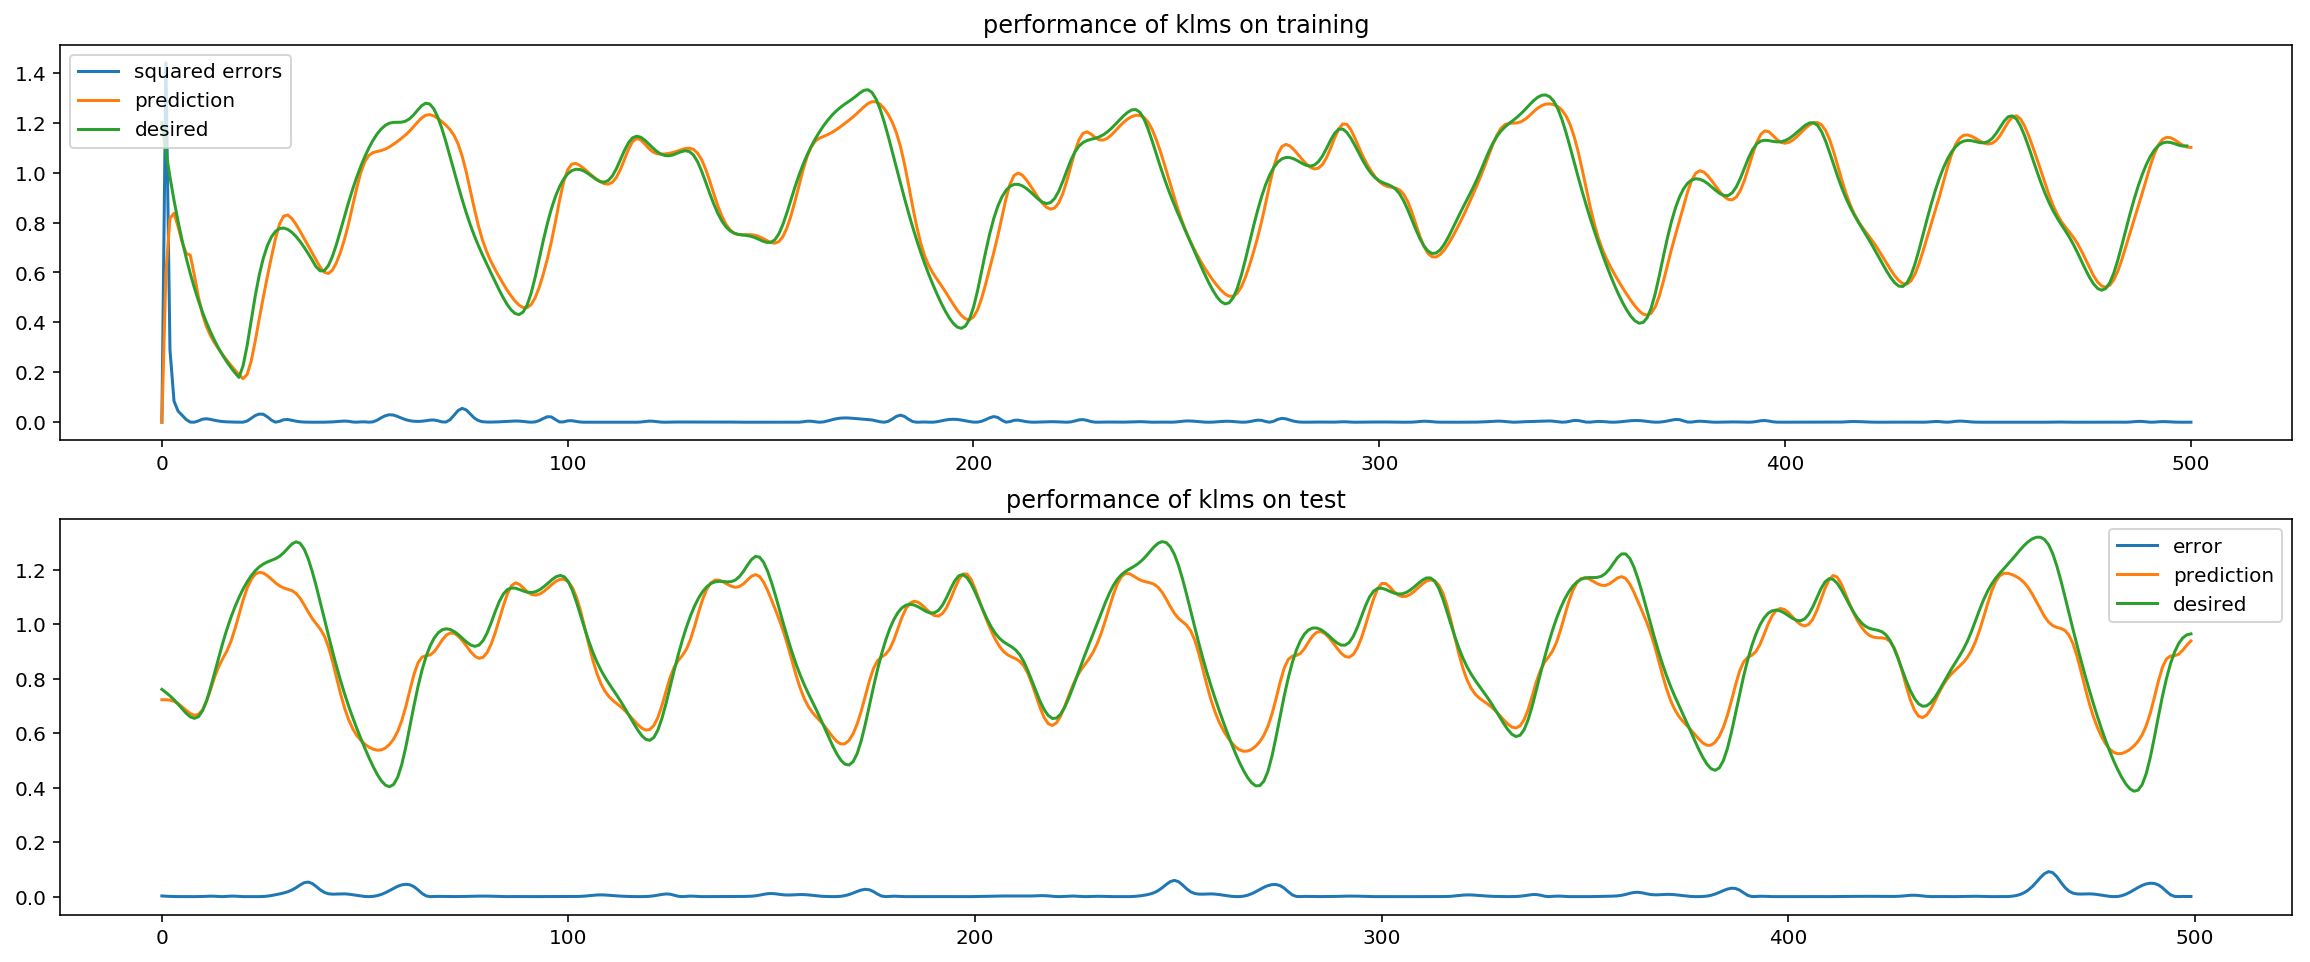

In [362]:
klms5 = KLMS(5,0.5,0.5)
klms5.train(X_train)
klms5.test(X_test)

plt.subplot(211)
plt.plot(klms5.train_errors,label='squared errors');
plt.plot(klms5.train_predictions,label='prediction');
plt.plot(X_train,label='desired');
plt.legend(); plt.title('performance of klms on training');
plt.subplot(212)
plt.plot(klms5.test_errors[500:1000],label='error')
plt.plot(klms5.test_predictions[500:1000],label='prediction')
plt.plot(X_test[500:1000],label='desired');
plt.legend(); plt.title('performance of klms on test');

In [432]:
print('mean squared test error is',np.mean(klms5.test_errors))

mean squared test error is 0.007702026517385476


## Finding Optimal Meta Parameters

In [386]:
def KLMS_trainconv(N,learnstep,sigma):
    klmsX = KLMS(N,learnstep,sigma)
    klmsX.train(X_train)
    plt.plot(klmsX.train_errors,label=str(learnstep)+','+str(sigma))
    plt.legend()
    MSE = np.mean(klmsX.train_errors)
    print(str(MSE)+' @ '+str(learnstep)+','+str(sigma))

0.6035397963675935 @ 0.01,0.1
0.14898095684124957 @ 0.1,0.1
0.04607973983280971 @ 0.5,0.1
0.03330511942563097 @ 1,0.1
0.18798155859413923 @ 0.01,0.5
0.026593172175362143 @ 0.1,0.5
0.007409911378206824 @ 0.5,0.5
0.005143254275245715 @ 1,0.5
0.13641424702997926 @ 0.01,1
0.022630940814414767 @ 0.1,1
0.006205025392666937 @ 0.5,1
0.004252617465041164 @ 1,1


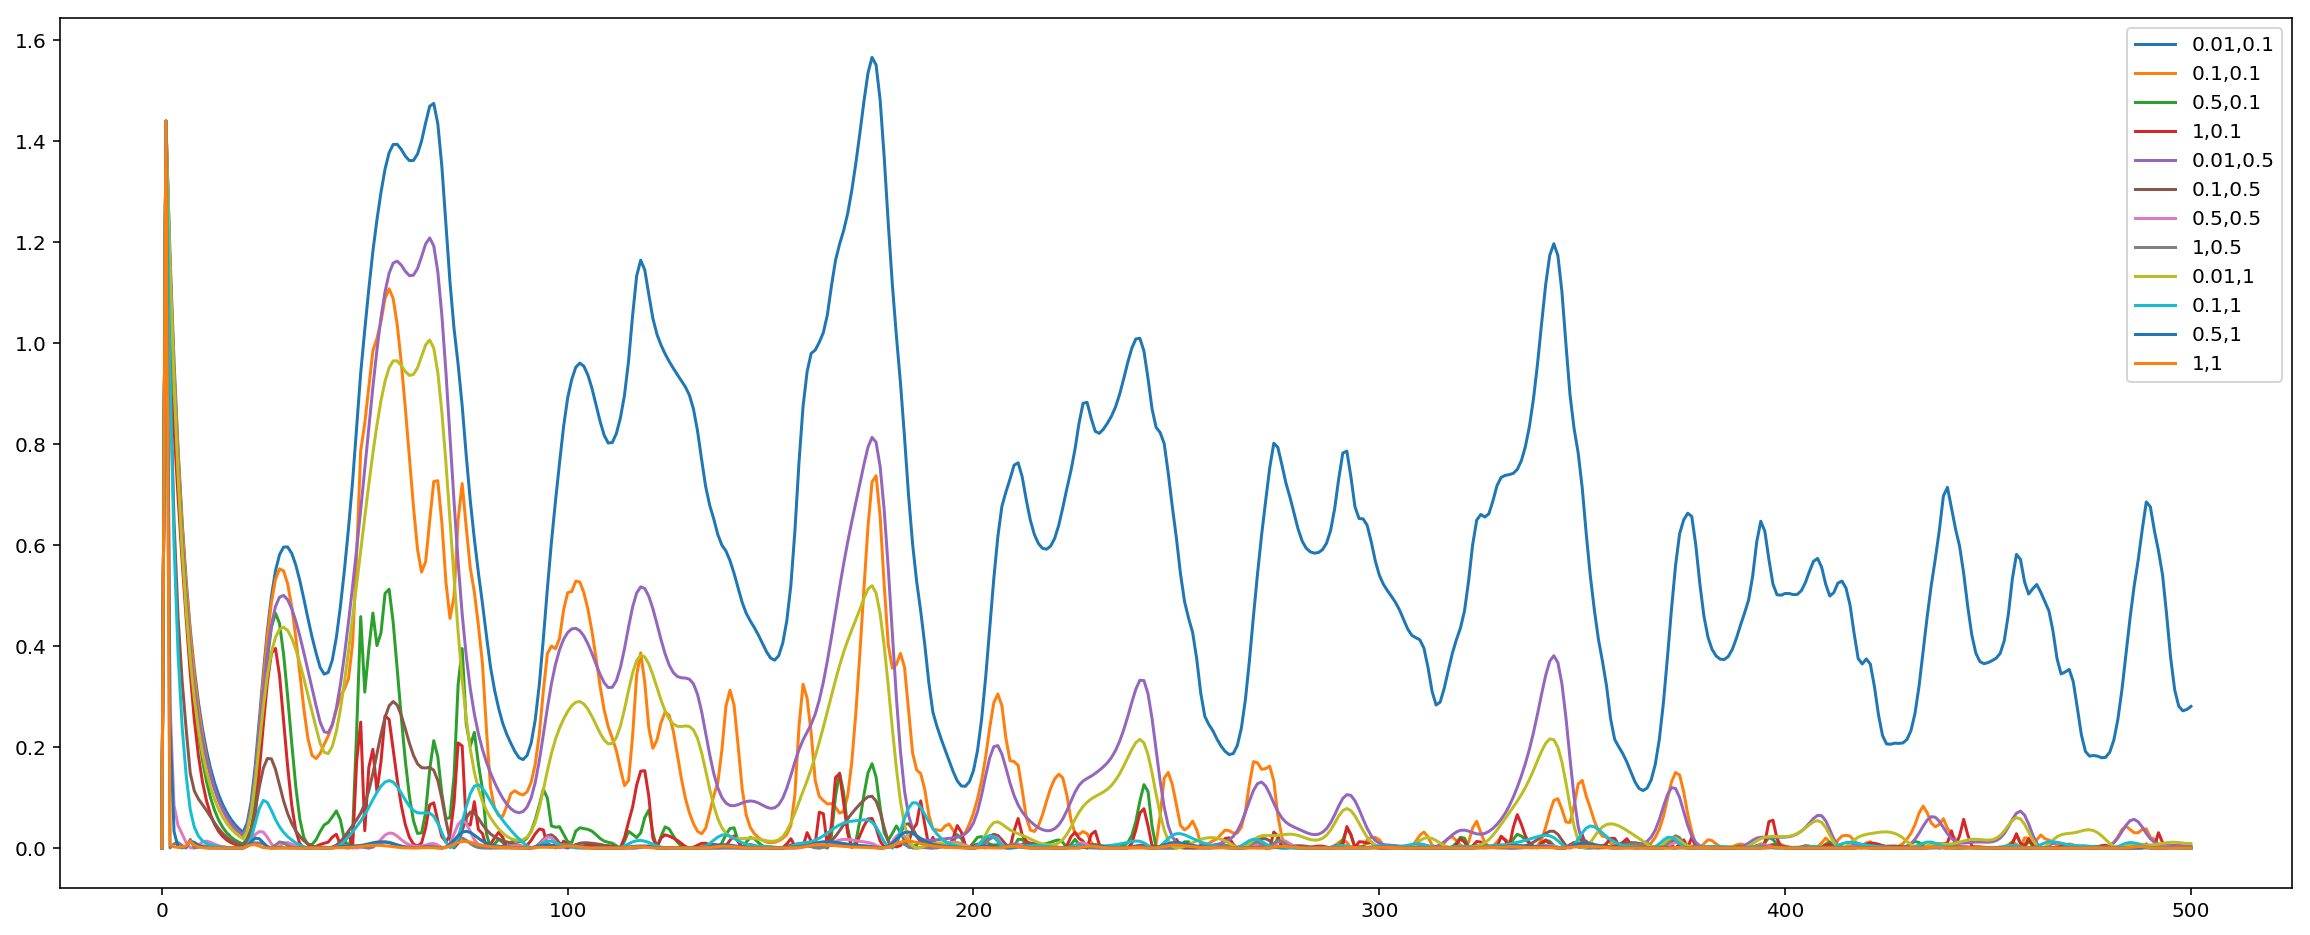

In [389]:
for sigma in [0.1,0.5,1]:
    for learnstep in [0.01,0.1,0.5,1]:
        KLMS_trainconv(5,learnstep,sigma)

0.7692969175198722 @ 0.01,0.1
0.37190408751439996 @ 0.1,0.1
0.12885191190517722 @ 0.5,0.1
0.08827830271508583 @ 1,0.1
0.2746639660252655 @ 0.01,0.5
0.04062474119108368 @ 0.1,0.5
0.011694930649485505 @ 0.5,0.5
0.007594847490730003 @ 1,0.5
0.16637013455391483 @ 0.01,1
0.02474322790966457 @ 0.1,1
0.006722509338149608 @ 0.5,1
0.004431734766294615 @ 1,1


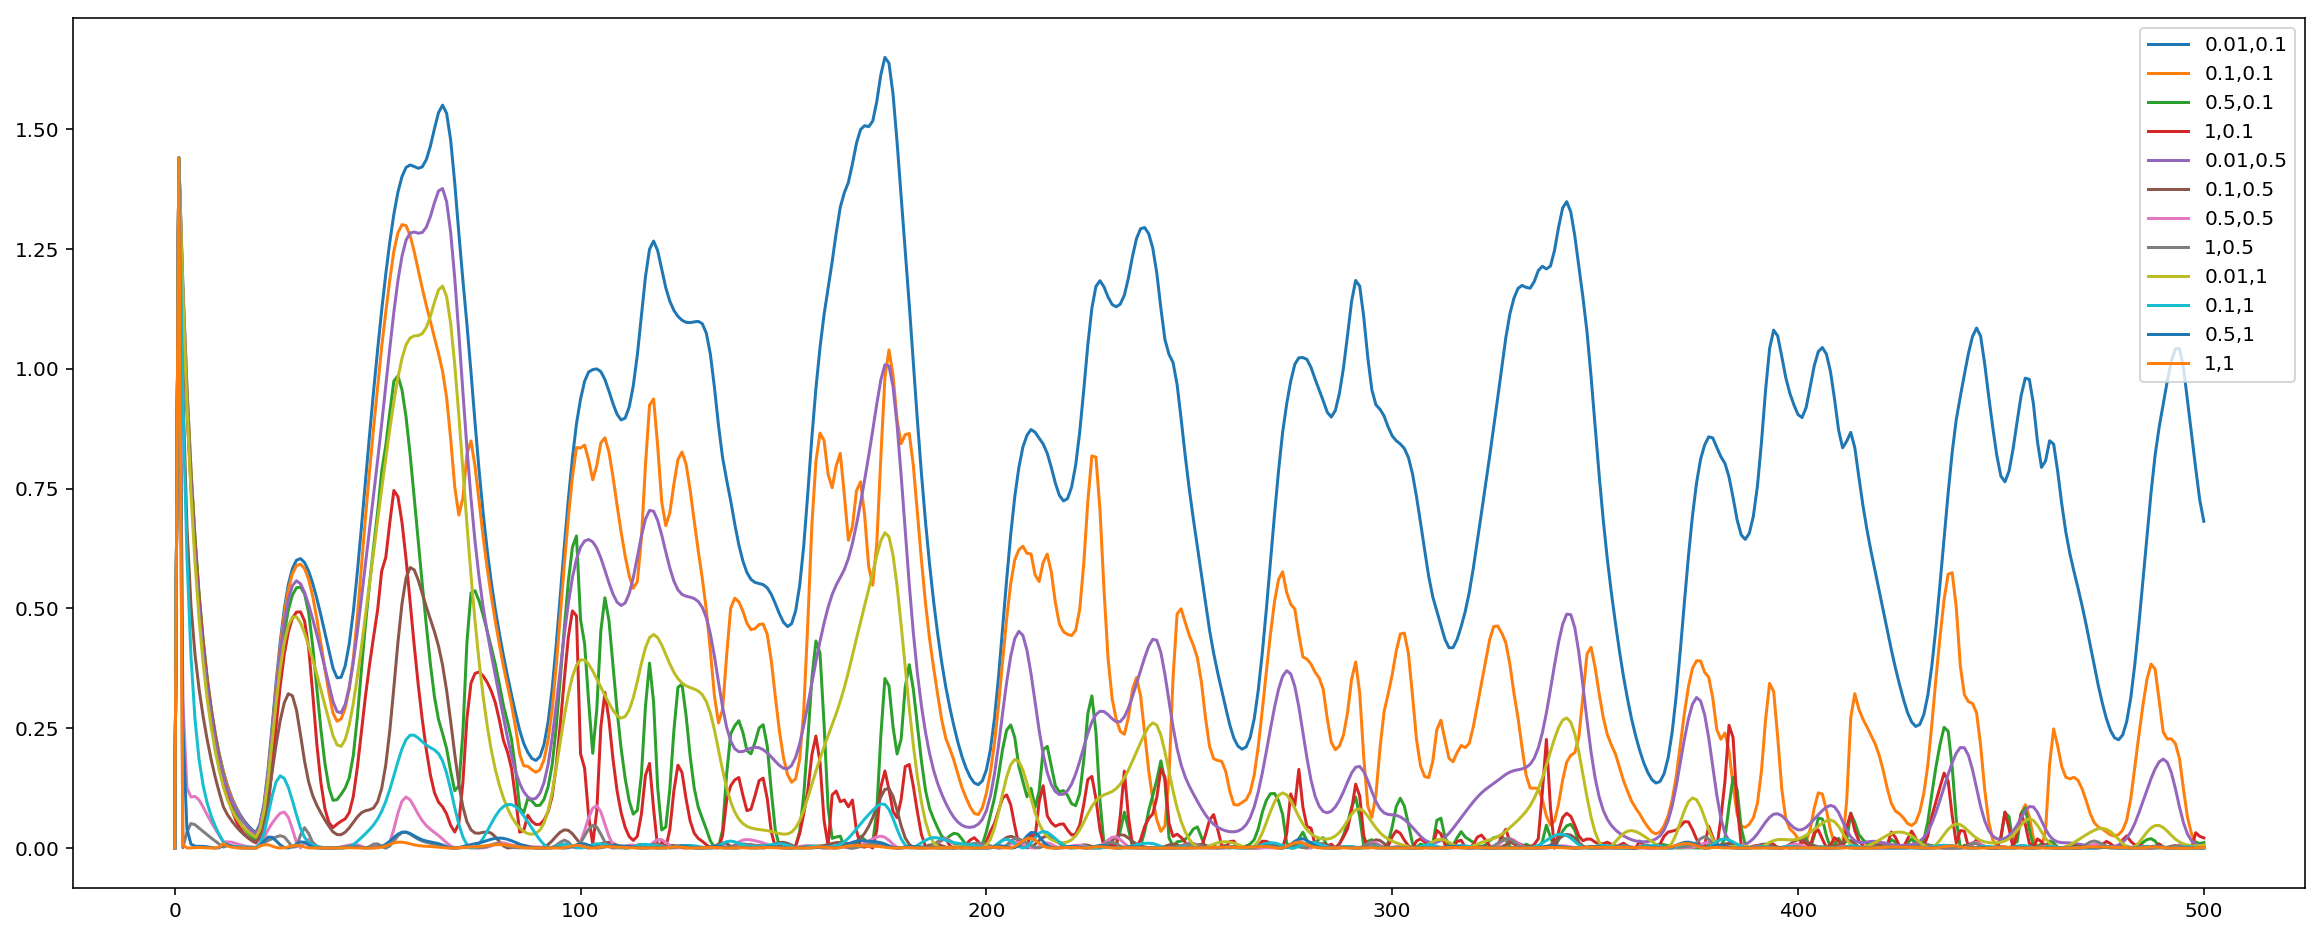

In [393]:
for sigma in [0.1,0.5,1]:
    for learnstep in [0.01,0.1,0.5,1]:
        KLMS_trainconv(10,learnstep,sigma)

By exploration we found that with increasing number learningstep size and increasing sigma we get a smaller error. This is the expected behaviour for increasing the model variance which happens because of the guassian kernel beeing very narrow at high values of sigma. 

A high training accuracy does not necessarily translate to a high test set accuracy. This is because with high model variance we run the risk of overfitting the dataset. We therefore check the achieved at the test also

In [395]:
def KLMS_testconv(N,learnstep,sigma):
    klmsX = KLMS(N,learnstep,sigma)
    klmsX.train(X_train)
    klmsX.test(X_test)
    plt.plot(klmsX.test_errors,label=str(learnstep)+','+str(sigma))
    plt.legend()
    MSE = np.mean(klmsX.test_errors)
    print(str(MSE)+' @ '+str(learnstep)+','+str(sigma))

0.4066327139938699 @ 0.01,0.1
0.014101910366978184 @ 0.1,0.1
0.004878133289310562 @ 0.5,0.1
0.01139024638885562 @ 1,0.1
0.025088573895443108 @ 0.01,0.5
0.00415915572986079 @ 0.1,0.5
0.007702026517385476 @ 0.5,0.5
0.01963790061815893 @ 1,0.5
0.020868887545762327 @ 0.01,1
0.006197075759312107 @ 0.1,1
0.005956349547460496 @ 0.5,1
0.01218123798751852 @ 1,1


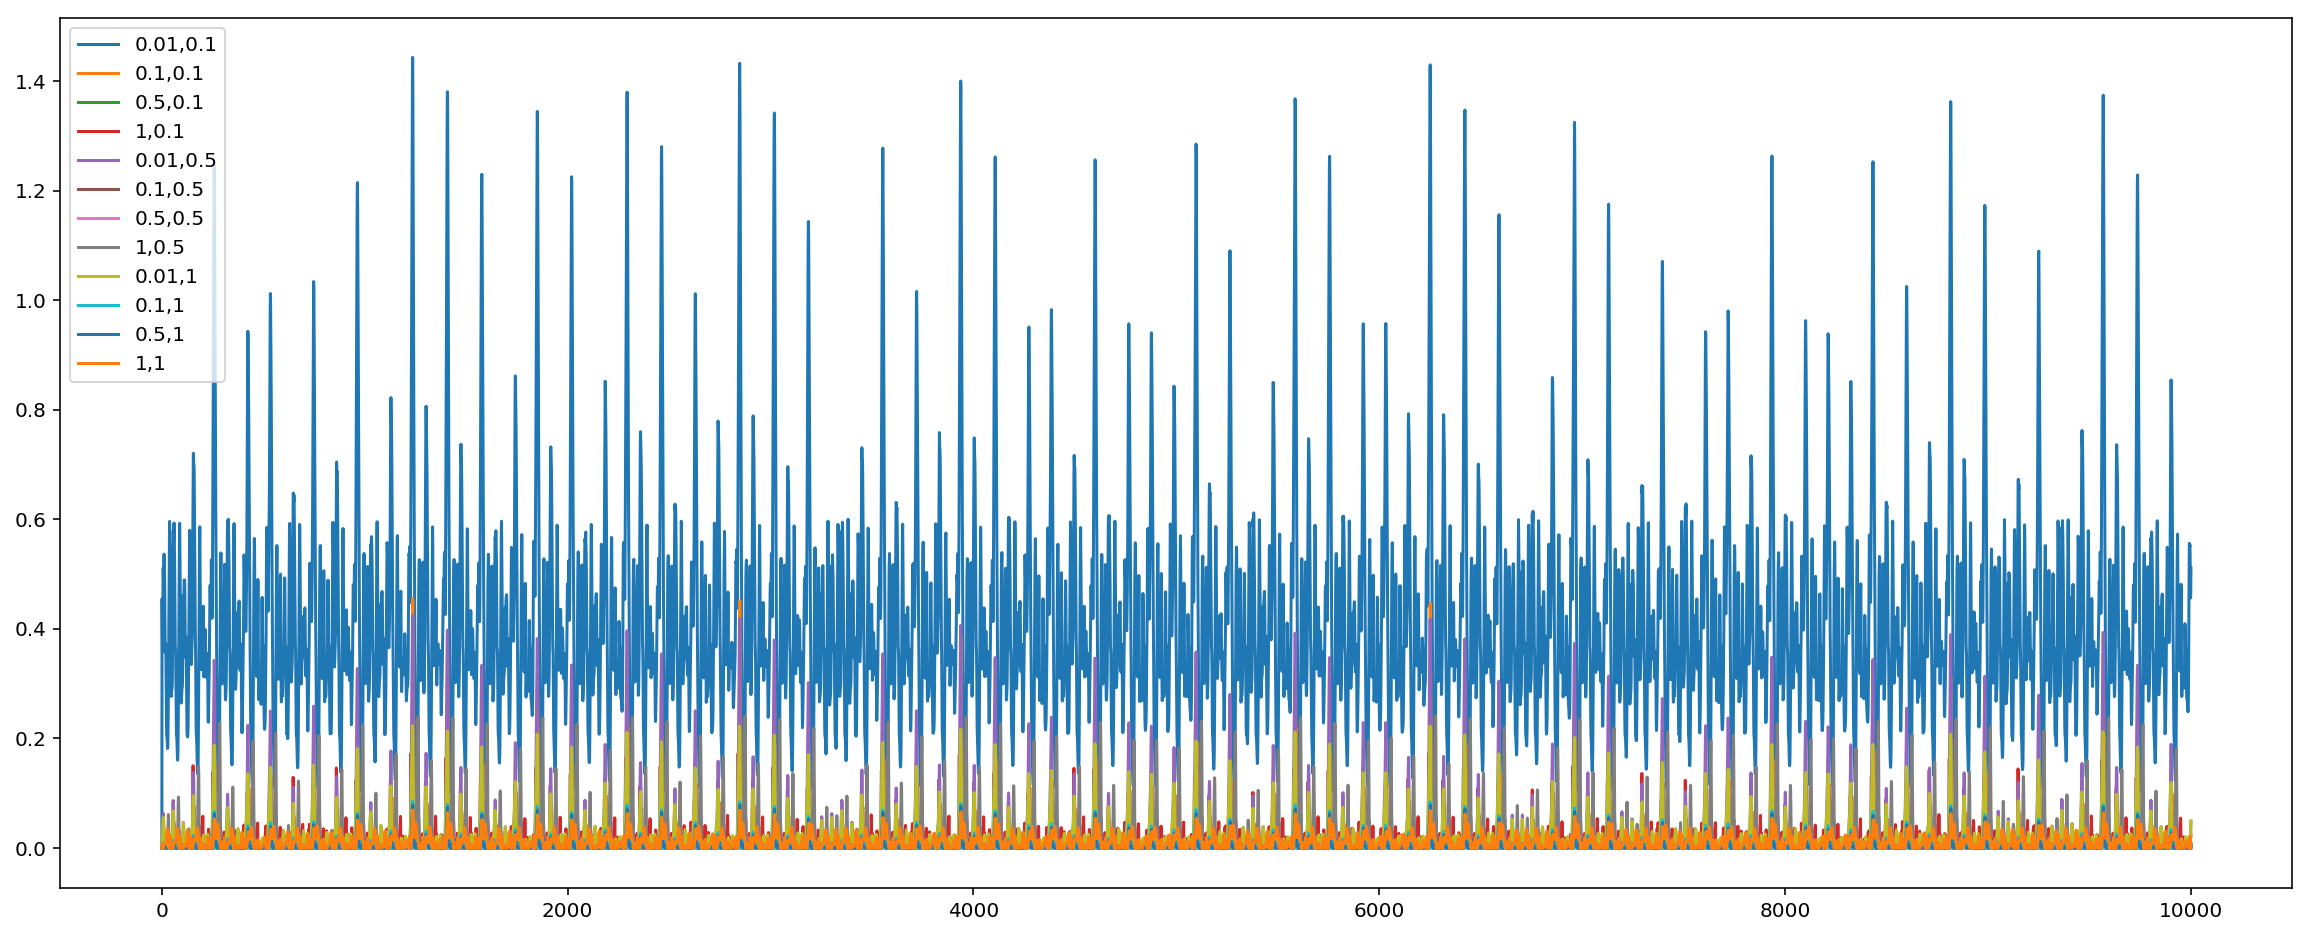

In [396]:
for sigma in [0.1,0.5,1]:
    for learnstep in [0.01,0.1,0.5,1]:
        KLMS_testconv(5,learnstep,sigma)

In the last two lines we note that the error increases altough learnstep size als increases. While in training the last setup achieved the best score we now see that the model was overfit. Therefore the optimal solution for N=5 is found at the case of learnstep=0.5 and sigma=1. By lowering the model variance we introduce a bias that prevents the overfitting. The final error is 0.005956349547460496 @ 0.5,1

0.6920249999404898 @ 0.01,0.1
0.10808127243869983 @ 0.1,0.1
0.025431594907499272 @ 0.5,0.1
0.06785862417505761 @ 1,0.1
0.05447401319498194 @ 0.01,0.5
0.006112581512492955 @ 0.1,0.5
0.010033260379459447 @ 0.5,0.5
0.028602206856755335 @ 1,0.5
0.026058951105737183 @ 0.01,1
0.00529868174264335 @ 0.1,1
0.015224252335260818 @ 0.5,1
0.0342495421773156 @ 1,1


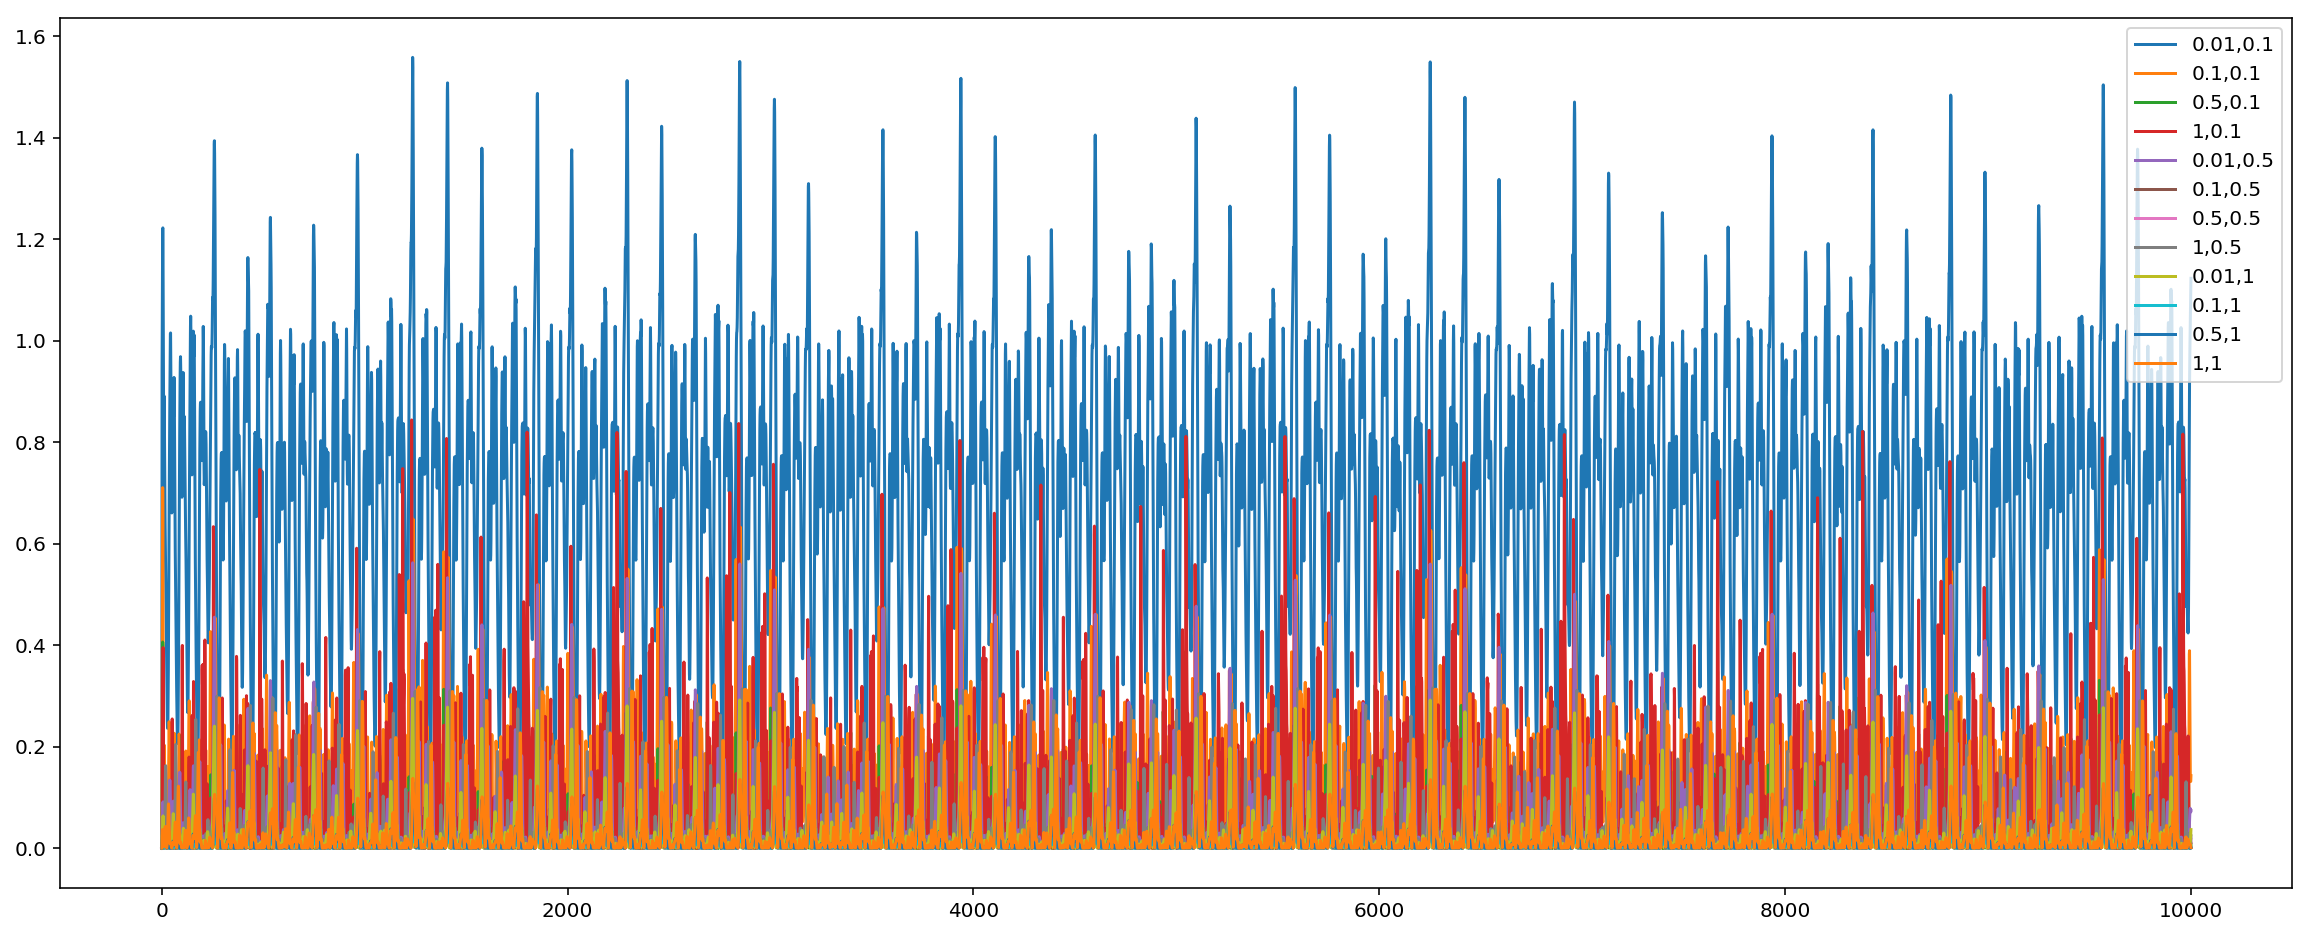

In [433]:
for sigma in [0.1,0.5,1]:
    for learnstep in [0.01,0.1,0.5,1]:
        KLMS_testconv(10,learnstep,sigma)

Here we can see that the best solution can be found with the case of a stepsize of 0.01 and sigma beeing 0.5. The error is: 0.006112581512492955 @ 0.1,0.5

It at first seems counter intuitive that the algorithm with more Taps ($N=10$) has the worse performance. However the training set size is rather limited and therefore we are prone to overfit. 

As we took the test set to determine the most suitible set of meta parameters our estimate is not equivalent to the generalization error any more. To achieve a measure of the generalization error also, we would have to split the test set in to what is usually called a validation and a test set. 

## Comparison to LMS

0.028576657669996817


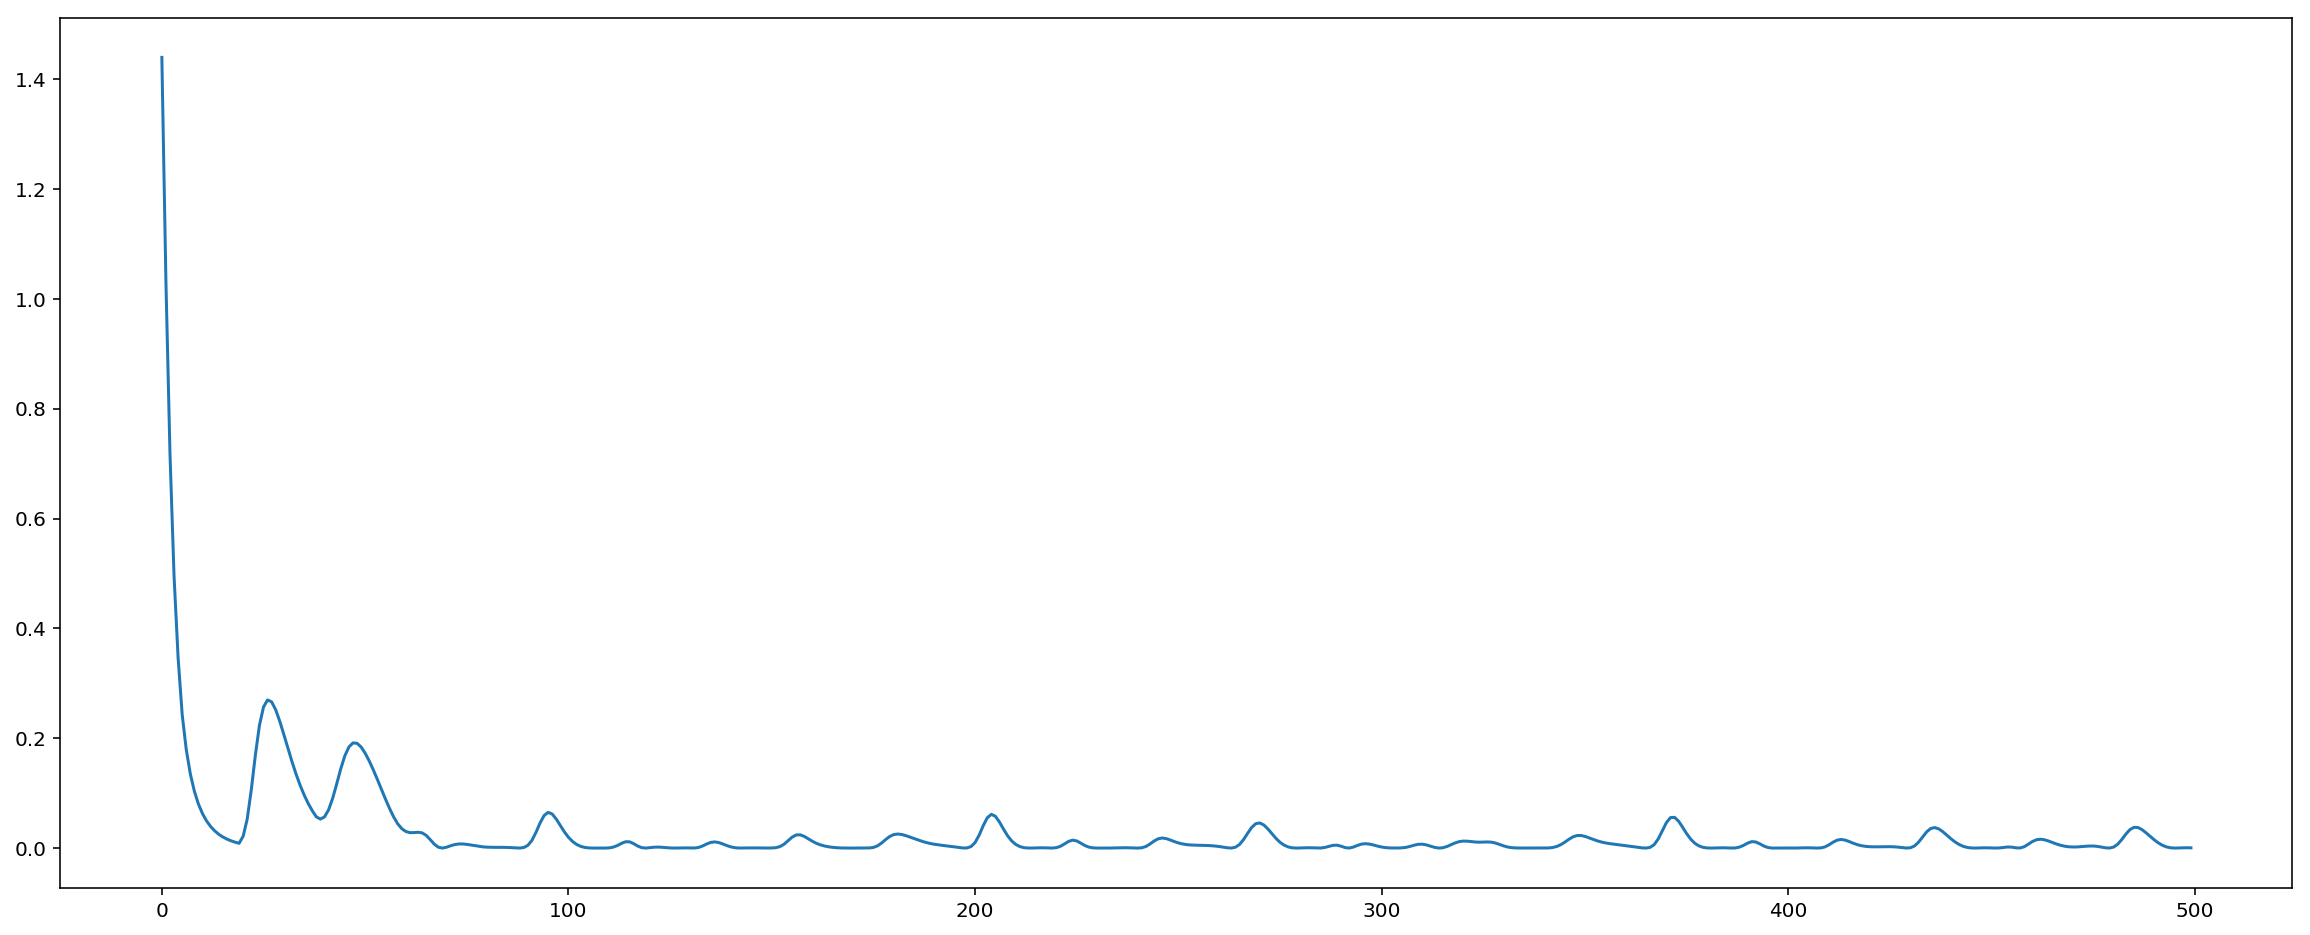

In [440]:
changemat_LMStrain = toeplitz(X_train)[:5,:]
X_trainLMS = changemat[1:5+1,:]
d_trainLMS = changemat[0,:]

plt.plot(lms(5,d_trainLMS,X_trainLMS)[1])
print(np.mean(lms(5,d_trainLMS,X_trainLMS)[1]))
weights_LMS = lms(5,d_trainLMS,X_trainLMS)[0][:,-1]

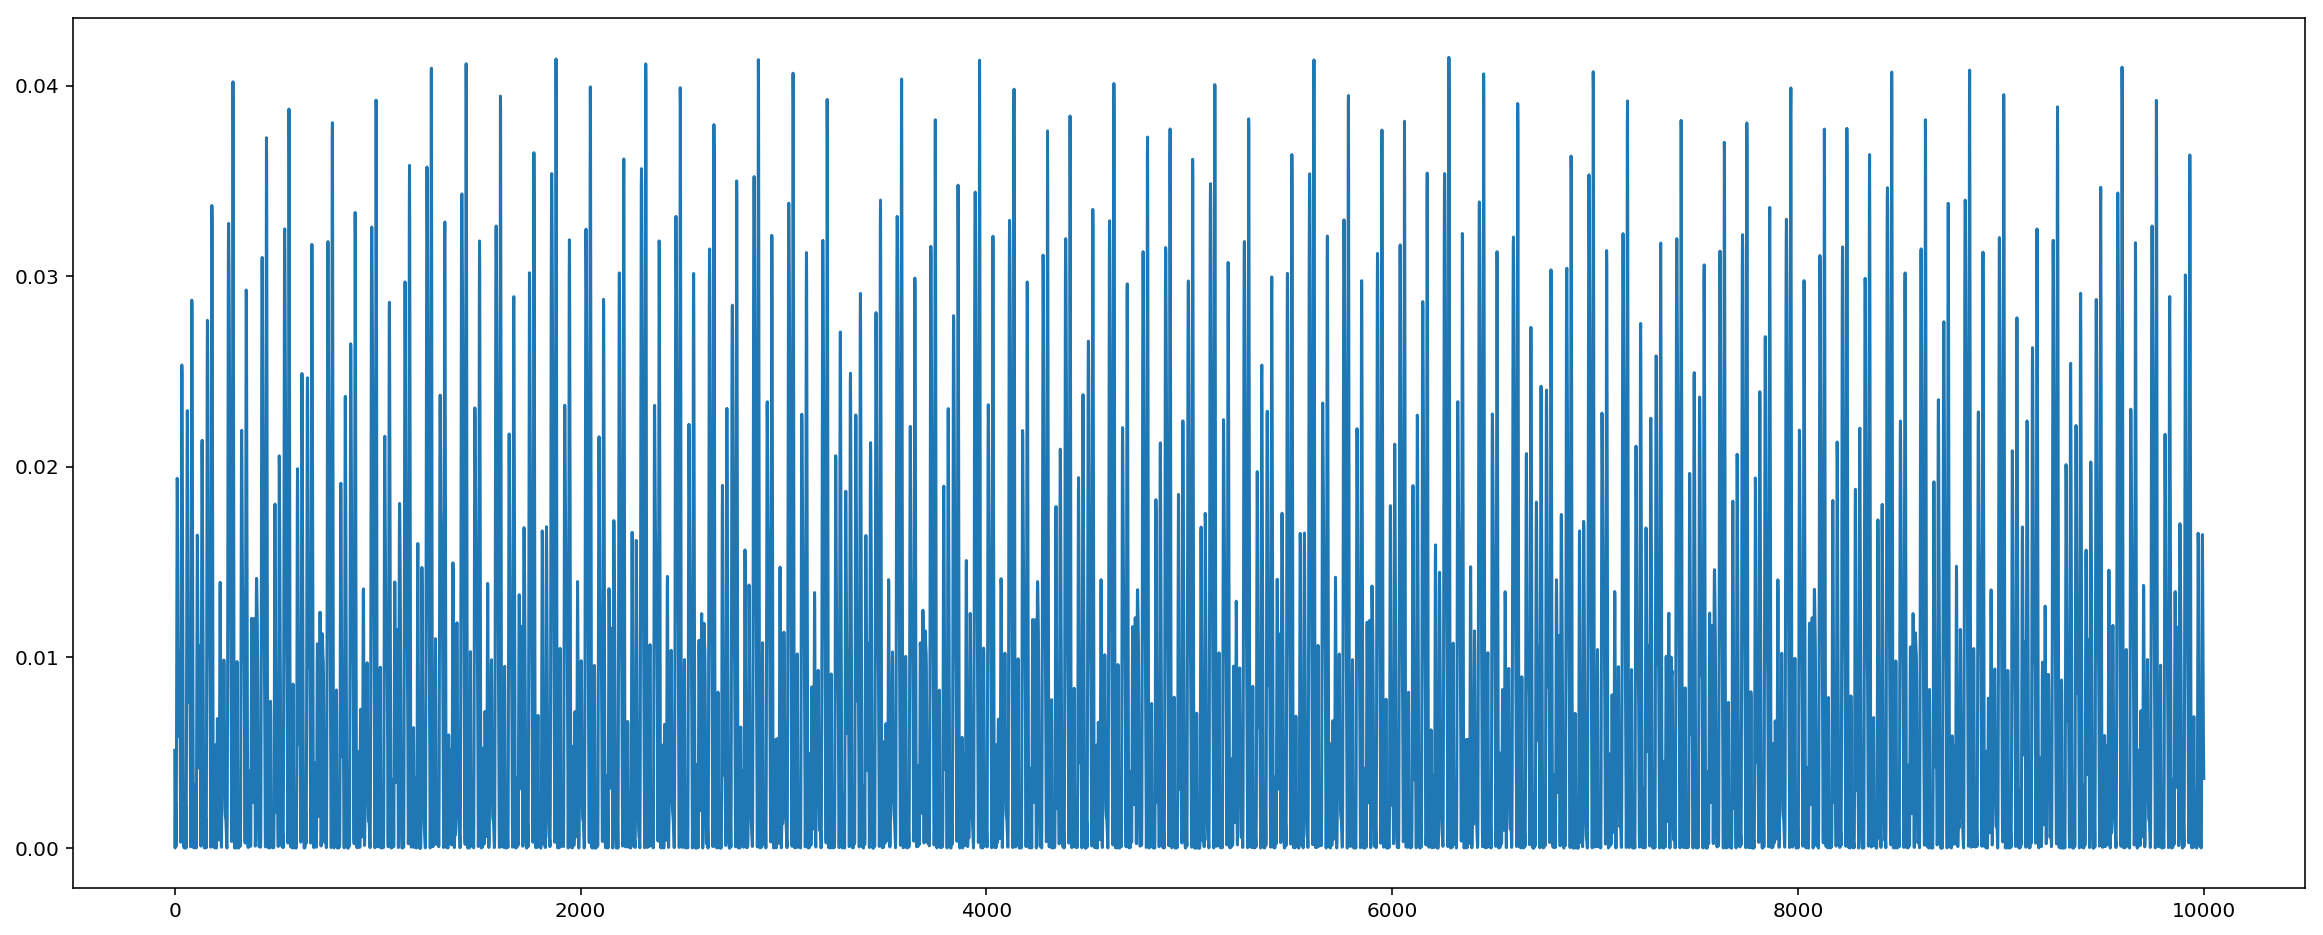

In [463]:
changemat_LMStest = toeplitz(X_test)[:6,:]
X_testLMS = changemat_LMStest[1:6,:]
d_testLMS = changemat_LMStest[0,:]

# prediction:
lms_test_errors = []
for i in range(len(d_testLMS)):
    estimate = weights_LMS@X_testLMS[:,i]
    lms_test_errors.append((d_testLMS[i]-estimate)**2)
plt.plot(lms_test_errors);

In [464]:
np.mean(lms_test_errors)

0.008348458054039238

The test error of the LMS turns out to be surprisignly good, taking into account that it beats most of the KLMS parametrizations. However we can clearly see, that it performs worse than both the KLMS with $N=5$ as well as the KLMS with $N=10$

# Error Function Visualization

In [465]:
# ideal filter:
R = np.array([[1,0],[0,1]])
p = np.array([0.7, 0.1])
w = np.array([ 1.20519592, -0.08201364])
sigma = 1
J = sigma + w@R@w + 2*p@w

In [466]:
def sig_stats(N,d,x):
    '''
    'N' numer of taps, 'd' Desired Signal, 'x' Input Signal
    Returns 'sigma', autocorrelation 'R' and crosscorrelation 'p'
    '''
    # initialize matrices
    X = toeplitz(x)[:N,:]
    R = np.zeros((N,N,x.shape[0]))
    p = np.zeros((x.shape[0],N))
    
    # for every time step i calculate the corresponding
    # autocorrelation matrix and crosscorelation matrix
    for i in range(0,x.shape[0]):
        x_i = X[:,i]
        p[i,:] = d[i]*x_i
        R_i = np.outer(x_i,x_i)
        R[:,:,i] = R_i
    sigma = rms(x)
    
    # take mean of all time steps
    Rmean = np.mean(R,axis=2)
    pmean = np.mean(p,axis=0)
    return sigma,Rmean,pmean

In [467]:
def error_fun(sig,R,p,w):
    '''
    returns the prediction error of a FIR Filter specified by w.
    requires the signal variance 'sig', the autocorrelation matrix 'R'
    and the crosscorrelation vector 'p' of disred vs input signal.
    '''
    J = sigma + w@R@w - 2*p@w
    return J

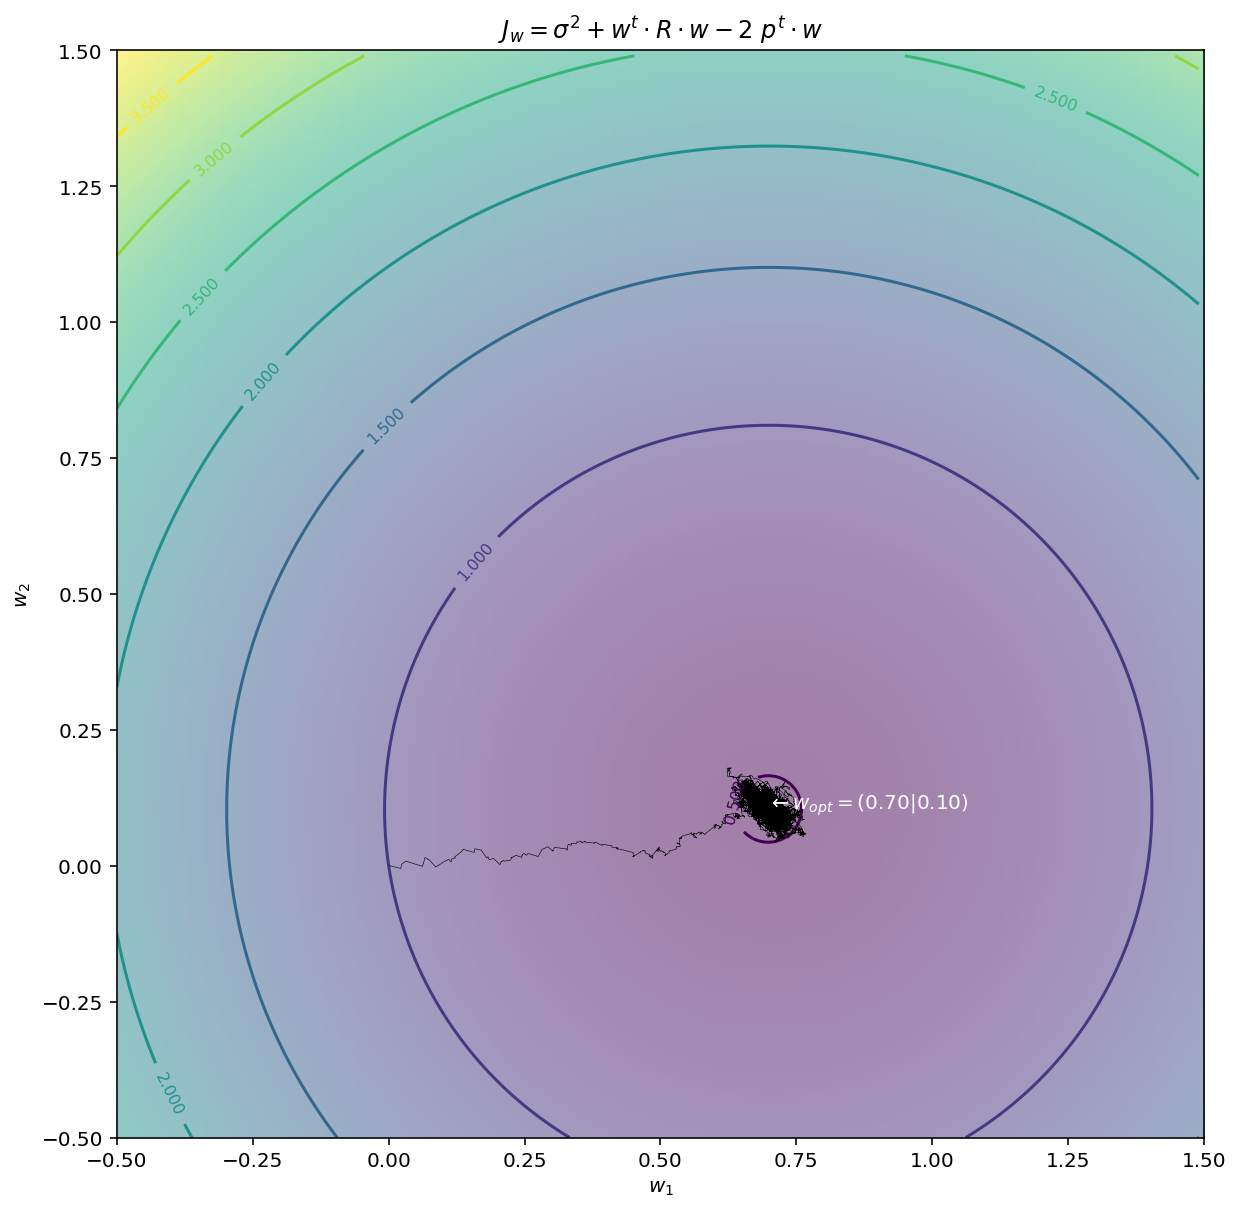

In [468]:
from scipy.linalg import inv

def plt_errsurf(mini,maxi,d,x):
    # get estimation of signal statistics
    sig,R,p = sig_stats(2,d,x)
    
    # calculate error surface
    wvals = np.arange(mini,maxi,0.01)
    J = np.zeros((len(wvals),len(wvals)))
    for i,w0 in enumerate(wvals):
        for j,w1 in enumerate(wvals):
            w = np.array([w0,w1])
            J[j,i] = error_fun(sig,R,p,w) 
    
    levels = np.arange(0,100,0.5)
    # give countours
    plt.figure(figsize=(10,10))
    contours = plt.contour(wvals,wvals,J)
    # label countours with corresponding value of J
    plt.clabel(contours, inline=True, fontsize=8)
    # fill with color gradient
    plt.imshow(J,extent=[mini,maxi,mini,maxi],origin='lower',alpha=0.5)
    
    # plot gradient descent
    w = lms(2,d,x)[0]
    plt.plot(w[0],w[1],'k',linewidth='0.3')
    
    # add annotation of optimal weight vector
    wopt = inv(R)@p
    annotation = (r'$\leftarrow w_{opt} = (%.2f|%.2f)$')
    position = (wopt[0],wopt[1])
    plt.annotate(annotation %position, position,color='w')
    #plt.text(0,0,r'with $ J_{w_{opt}}=%.2f$' % (error_fun(sig,R,p,wopt)))
    
    # add title and labels for axis
    plt.xlabel('$w_1$'),plt.ylabel('$w_2$')
    plt.title(r'$J_w = \sigma^2 + w^t\cdot R \cdot w - 2\ p^t \cdot w$')
    return w
   
w = plt_errsurf(-.5,1.5,addnoise(Dfir,0.001),Xfir)

## Literature:

[1] Moschytz, G., & Hofbauer, M. (2000). Adaptive Filter. Berlin ua: Springer.

[2] Liu, W., Principe, J. C., & Haykin, S. (2011). Kernel adaptive filtering: a comprehensive introduction (Vol. 57). John Wiley & Sons.